# World Data League 2022

## 🎯 Challenge
*Identification of Dark Ecological Corridors*


## Team: Pablitos
## 👥 Authors
* Marcelo Moreno
* Beatriz Barretto
* Hiba Laziri
* Joana Camargo

## 💻 Development


All files required to run the code can be found in the following drive: https://drive.google.com/drive/folders/17dFvZAkYf4TbQ57n8DEm371JqBLOlWPX?usp=sharing .

### Loading Libraries

In [517]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import random
import numpy as np
from re import search
from shapely.geometry import Point, shape, LineString
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
import itertools
from time import time
from IPython.display import Image
import matplotlib.pyplot as plt

### Exploratory Data Analysis

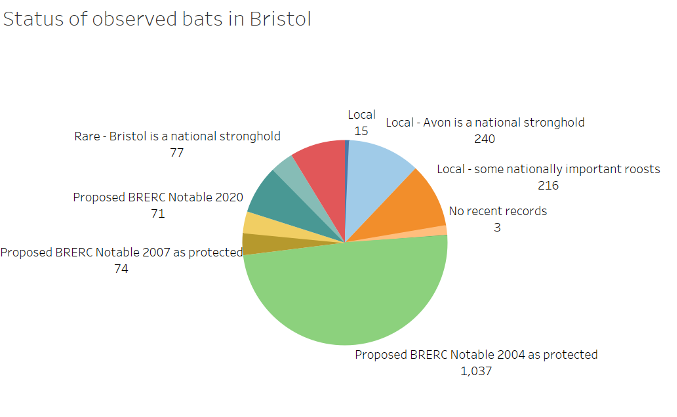

In [518]:
Image("EDA/EDA_1.png")

This pie chart shows the distribution of the bat species that are local to Bristol, rare or protected by the UK government . As one can see about 68% of the bats are protected by law from the last 15 years and 27% were local species in Bristol.

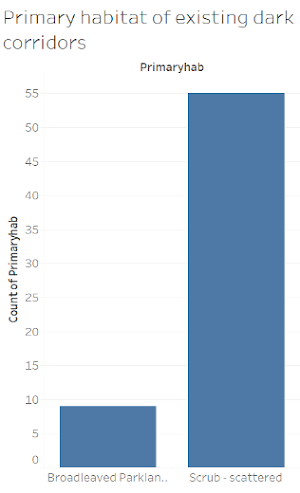

In [519]:
Image("EDA/EDA_2.png")

This graph shows that 55 of the 63 habitats in Bristol that have dark corridors are in scrubs scattered throughout the city and only 8 of the 63 habitats are in park areas. This means that the park areas where it would be more likely for bats to shelter in, still have light which is damaging for the bats themselves.

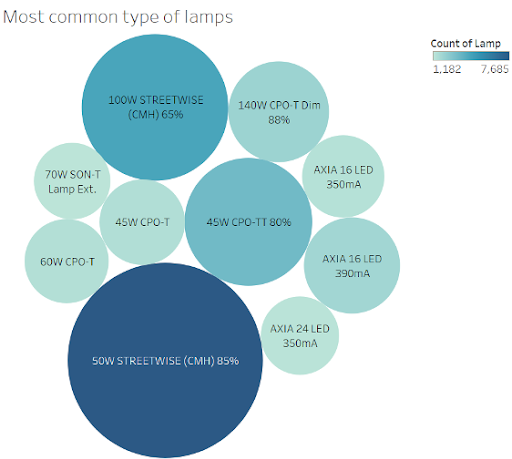

In [520]:
Image("EDA/EDA_3.png")

This bubble chart shows the proportion of types of lamps present in Bristol. The 50W STREETWISE (CMH) represents the most type of street lamp. This data is very useful for the final model since light affects the bats differently depending on the ultraviolet spectrum emitted by the lamp. But due to the lack of reliable and complete information on how different species are affected by different types of lights, we did not end up using that for our algorithms (we preprocessed the data as if we would but later realized we wouldn't use it).

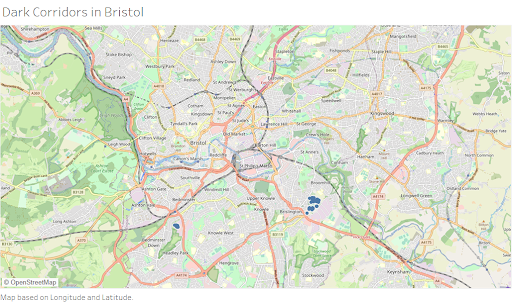

In [521]:
Image("EDA/EDA_4.png")

This map reveals the number of dark corridors that already exist in Bristol. As it can be observed, there are only a few dark corridors already present in the city and most of them are located in the same area. This means that creating other corridors is an important matter for the city council.

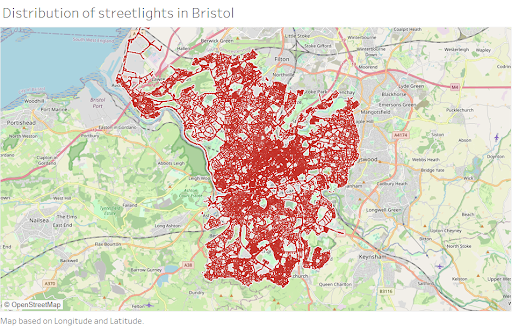

In [522]:
Image("EDA/EDA_5.png")

This map shows the distribution of streetlights in Bristol. This data is very important since it will be used in order to create the dark corridors.

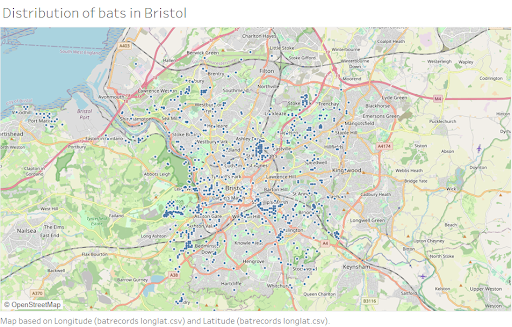

In [523]:
Image("EDA/EDA_6.png")

This map shows the distribution of bats in Bristol. This data is very important since it will be used it in order to find the locations where most of bats are located in order to create the dark corridors.

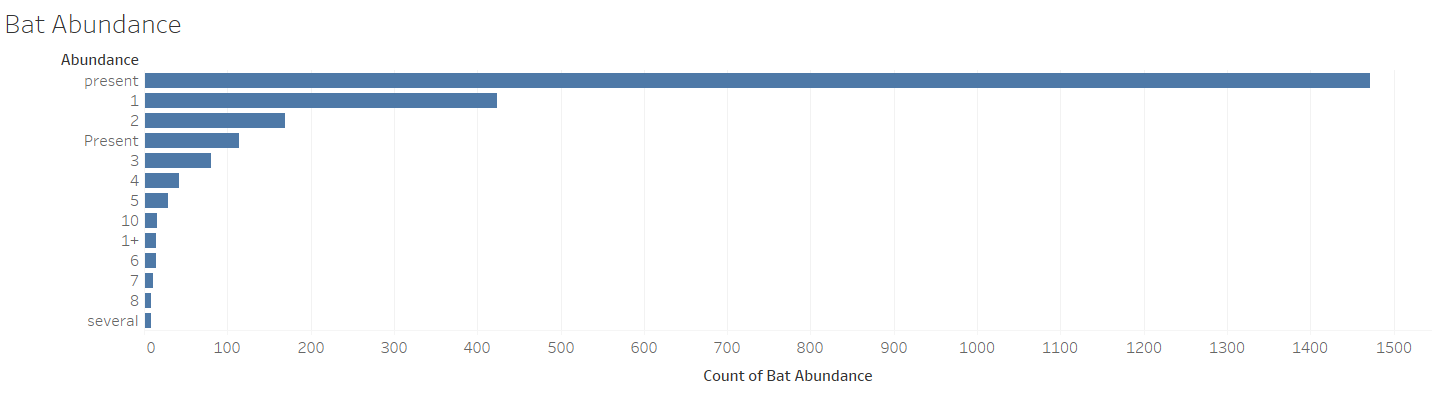

In [524]:
Image("EDA/EDA_10.png")

The bar graph shows the top most common values in the Bats dataset in the Abundance column. We can see that in many cases a number is not given but instead a word such as 'present' is used. We will have to deal with this once we are doing the data preprocessing

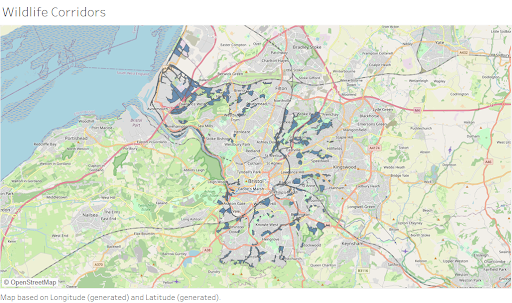

In [525]:
Image("EDA/EDA_7.png")

This map shows the distribution of Wildlife Corridors in the city of Bristol.

### Data Preprocessing

#### Loading Datasets

In [526]:
lights = pd.read_csv('streetlights_2022.csv')
bats = pd.read_csv('bat_records.csv')
moths = pd.read_csv("noctua_pronuba.csv").rename(columns={'Grid_Ref': 'GRID_REF'})
dark = pd.read_csv("dark_corridors.csv")
wc = pd.read_csv("wildlife_corridors.csv")


# creating a list of the datasets that we will have to deal with in the next section
datasets = [lights, bats, moths, dark]
names = ["lights", "bats", "moths", "dark"]

#### Dealing with Grid References

For our optimization algorithm we decided to try and find the best possible setting of light for each grid reference that contains at least one streetlight. We decided to take grid references with a specification of 8 total characters (e.g. "ST543789"). Thus, each grid reference covers an area of 100m * 100m. Some of the datasets such as the streetlights and the dark corridors datasets do not include the grid reference, therefore, we added it using the following website: https://gridreferencefinder.com/batchConvert/batchConvert.php. Additionally some of the grid references in the other datasets are not in a 8 character format so this has to be dealt with as well.

In [527]:
# loading txt files that contain grid references
lights['GRID_REF'] = pd.read_csv("lights_grid.txt", header=None).iloc[:, 2]
dark['GRID_REF'] = pd.read_csv("dark_grid.txt", header=None).iloc[:, 2]

In [528]:
# creating a function that will help us check that all grid references contain 8 characters
def GR_lengths(dataset, name):
    lengths = dataset["GRID_REF"].apply(len).unique()
    print(name, ":", lengths)


# running the function in the list of datasets previously created
for i in range(len(datasets)):
    GR_lengths(datasets[i], names[i])

lights : [12]
bats : [ 8  6 10 12]
moths : [ 8 12  6 10]
dark : [12]


We can see that some of the grid references contain 6, 8, 10 and 12 characters. To deal with the references containing 10 and 12 characters we just need to remove some of the numbers. However, to deal with the grid reference that contains 6 characters it is more complicated because this reference corresponds to a 1km * 1km grid which means that we would have 100 different options on where to convert that 6 character grid into a 8 character grid. For the bat dataset we also have Easting and Northing, therefore we decided to convert the Easting and Northing to a grid reference, that way we don't have to assign a value to a random grid out of the 100 possible options. For the nocturna pronuba dataset the latter option makes the most sense though as we don't have information on the Easting and Northing.

In [529]:
# loading txt file that contains grid references based on the Easting and Northing
bats['GRID_REF'] = pd.read_csv("bats_grid.txt", header=None).iloc[:, 2]

Now if we run the GR_length function again we will see that the bats dataset now has all the grid references with 12 characters

In [530]:
for i in range(len(datasets)):
    GR_lengths(datasets[i], names[i])

lights : [12]
bats : [12]
moths : [ 8 12  6 10]
dark : [12]


Now we can define a function that will change all the grid references into the desired format. To get an idea of what we want to do here imagine we have a 12 character grid reference "ST5674278912", this can be separated into 3 components: ST 56742 78912. The first two letters indicate a UK grid that is 100km * 100km across, the first number indicates the Easting (along corridor), the second number indicates the Northing (up the stairs). Therefore, to simplify the 12 character grid into an 8 character grid the three components of the example above would be: ST 567 789. Thus, it would be written as "ST567789". The same would apply for the 10 character grid references and for the 6 character grid reference we would be adding a number (random in this case) to the easting and northing components instead of removing it. The function below does exactly what has just been described.

In [531]:
def grid(grid):
    length = len(grid)
    if length == 8:
        return grid
    elif length == 10:
        new_grid = grid[0:5] + grid[-4:-1]
        return new_grid
    elif length == 12:
        new_grid = grid[0:5] + grid[-5:-2]
        return new_grid
    elif length == 6:
        new_grid = grid[0:4] + str(random.randint(0, 9)) + grid[-2:] + str(random.randint(0, 9))
        return new_grid

In [532]:
#applying the grid function to each of the datasets we are interested in
for i in range(len(datasets)):
    datasets[i]["GRID_REF"] = datasets[i]["GRID_REF"].apply(grid)

# checking to see if now the grid references are in the desired format
for i in range(len(datasets)):
    GR_lengths(datasets[i], names[i])

lights : [8]
bats : [8]
moths : [8]
dark : [8]


Now we have all of the grid references in the desired format. We can see below how many different grid references we have for each dataset. Given that the dark corridors appear in only 16 grid reference we will not be using it.

In [533]:
for i in range(len(datasets)):
    print(names[i], ":", len(datasets[i].GRID_REF.unique()))

lights : 7505
bats : 640
moths : 128
dark : 16


#### Dealing with Abundance

As our optimization algorithm will search for the optimal light setting in each grid we needed to connect all the datasets by grid reference. An essential variable of the bats and the nocturna pronuba datasets is the "Abundance" variable which indicates how many bats or moths were recorded. As we saw in the EDA, a lot of the values for these were not actually numbers but strings such as "present", "abundant", "several", "many", "few", etc... Some of the values were null as well. We needed to make a decision as to what numbers these words would represent, it will probably not be completely accurate but it wouldn't make sense to delete them as there are too many such observations. Instead of assigning a single value to each word we believed it was better to enter a range and assign a random value within that range. The conversions can be seen in the function below.

In [534]:
def bat_abundance(abundance):
    abundance = abundance.lower()  # some of the words were capitalized in some cases thus we converted everything to lower case to make the function simpler
    if abundance == "present":
        return random.randint(10, 50)
    elif abundance == "abundant":
        return random.randint(100, 200)
    elif abundance == "many":
        return random.randint(50, 100)
    elif abundance == "several":
        return random.randint(5, 10)
    elif abundance == "few":
        return random.randint(2, 5)
    elif abundance == "10 approx":
        return random.randint(9, 11)
    elif abundance == "2-3":
        return random.randint(2, 3)
    elif abundance == "none":
        return 0
    elif abundance == "2+":
        return random.randint(2, 5)
    elif abundance == "1+":
        return random.randint(1, 3)
    else:
        return int(abundance)

In [535]:
random.seed(2022)
bats.ABUNDANCE = bats.ABUNDANCE.apply(bat_abundance)

In [536]:
def moth_abundance(abundance):
    abundance = abundance.lower()  # some of the words were capitalized in some cases thus we converted everything to lower case to make the function simpler
    if abundance == "present":
        return random.randint(50, 100)
    elif abundance == "abundant":
        return random.randint(150, 300)
    else:
        return int(abundance)

In [537]:
random.seed(2022)
moths.Abundance = moths.Abundance.apply(moth_abundance)

As our optimization algorithm will want to take into account the locations of the bats and moths and their abundance to take lighting decisions for the present, we decided to only use information about bats from 2000 onwards as anything before that might not be true nowadays considering the rapid physical changes cities go through. Additionally, since there is a lot of data from 2000 onwards those data points can give us a better understanding of where bats are being observed nowadays.

In [538]:
# filtering for year 2000 onwards
bats = bats.loc[bats.YEAR_DATE >= 2000, :]
moths = moths.loc[moths.Year_Date >= 2000, :]

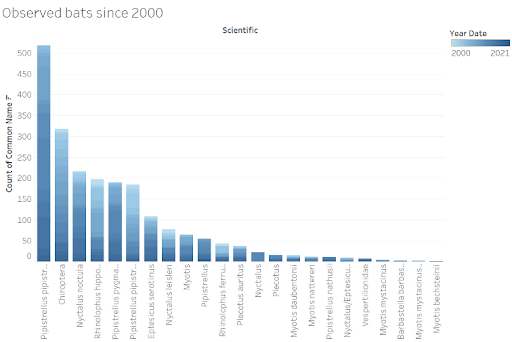

In [539]:
Image("EDA/EDA_8.png")

This bar chart shows the number of bats per type of species. The Pipistrellus pipistrelle is the most common type of bats with more than 500 bats of this type observed since 2000, followed by Chiroptera and Nyctallus Noctula. This will be important to take into account to create accurate dark corridors that suit the habits of each species.

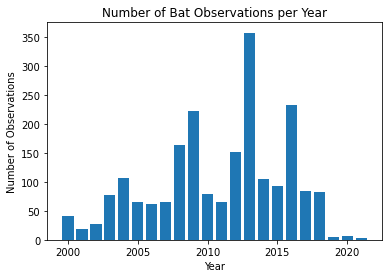

In [540]:
plt.bar( bats.YEAR_DATE.value_counts().index, bats.YEAR_DATE.value_counts())
plt.title("Number of Bat Observations per Year")
plt.ylabel("Number of Observations")
plt.xlabel("Year")
plt.show;

There are very few observations in recent years. This will significantly impact how well our algorithm and proposal would were if implemented in real life. We suggest improving the data collection on bats to be able to determine with more confidence which street lights should be turned off.

#### Type of light source

One of the variables that we found out could affect bats activity is the type of light source. Therefore, we decided to reduce the 'Lamp' variable which indicates the exact name of the lamp and its brand into just 5 different categories of lights. The five categories can be seen in the function below.

NOTE: Again, we did not use this in the end because of lack of information on how different bats respond to different lights. We have left the code because the rest of the preprocessing was done as if we were going to use it so changing everything would have taken some time and was not really necessary.

In [541]:
def lamp_type(lamp):
    if bool(search("LED", lamp)):
        return "LED"
    elif bool(search("SON", lamp)):
        return "SON"
    elif bool(search("SOX", lamp)):
        return "SOX"
    elif bool(search("CDM-T", lamp)) or bool(search("CDMT", lamp)) or bool(search("HQI", lamp)) or bool(
            search("CPO-T", lamp)) or bool(search("METAL HALIDE", lamp)) or bool(search("CMH", lamp)):
        return "Metal halide"
    else:
        return "Other"

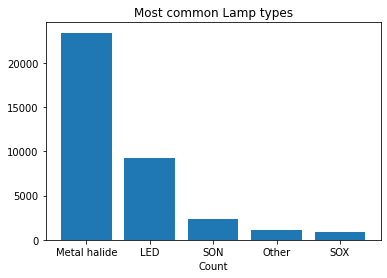

In [542]:
# applying the lamp_type function
lights["lamp_type"] = lights.Lamp.apply(lamp_type)

# counting the observations per type of lamp
plt.bar(lights.lamp_type.value_counts().index, lights.lamp_type.value_counts())
plt.title("Most common Lamp types")
plt.xlabel("Lamp type")
plt.xlabel("Count")
plt.show;

As we can see above the most commonly used types of lamp a re Metal halides and LED's

#### Genus of Bat

One of the most important components that we found in the research is how each genus of bats are affected by light. Not all bats are affected by light in the same way. However, some of the genus are affected similarly by light. Before classifying the bats based in how they are affected by light we first wanted to see how many of each species we had. Therefore, we created the function that can be seen below which can help us classify the specific Scientific Name of bats into something more generalizable: their genus.

In [543]:
def bat_genus(bat):
    if bool(search("Pipistrellus", bat)):
        return "Pipistrellus"
    elif bool(search("Myotis", bat)):
        return "Myotis"
    elif bool(search("Plecotus", bat)):
        return "Plecotus"
    elif bool(search("Nyctalus", bat)):
        return "Nyctalus"
    elif bool(search("Rhinolophus", bat)):
        return "Rhinolophus"
    elif bool(search("Eptesicus", bat)):
        return "Eptesicus"
    elif bool(search("Barbastella", bat)):
        return "Barbastella"
    else:
        return bat

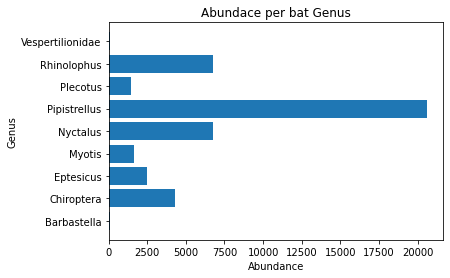

In [544]:
# applying the bat_genus function
bats["genus"] = bats.SCIENTIFIC.apply(bat_genus)

# counting the number of bats per genus
plt.barh(bats.groupby("genus").agg({"ABUNDANCE": "sum"}).index, bats.groupby("genus").agg({"ABUNDANCE": "sum"}).ABUNDANCE)
plt.title("Abundace per bat Genus")
plt.ylabel("Genus")
plt.xlabel("Abundance")
plt.show;

As can be seen above, the most common type of bat is the Pipistrellus and Nyctalus and the least common are the Barbastella and the Vespertilionidae which are barely present.

We researched the behavior with light of the different genus of bats and we found the following article which describes exactly that: https://link.springer.com/chapter/10.1007/978-3-319-25220-9_7. From the results found in the section '7.8 Experimental Studies on Bats at Street Lights' we draw the following conclusion:

- Highly affected by any level of luminance (don't move much in the presence of light): Plecotus and Myotis.
- Affected by light (don't move much in the presence of light but do so more than the above category): Eptesicus and Nyctalus
- Moderately affected by light (they are less affected by light when the luminance is low): Rhinolophus
- Barely affected by light (move more with light but become easier prey): Pipistrellus

We are still missing three genus of bats to classify: Vespertilionidae, Barbastella and Chiropetra (which isn't actually a genus).

In [545]:
bats.COMMON_NAM[bats.genus == "Chiroptera"].value_counts()

a bat (unidentified)    318
Name: COMMON_NAM, dtype: int64

As can be seen all the bats with genus "Chiroptera" are actually unidentified. They have been called Chiroptera because all bats are mammals of the order Chiroptera. We are going to assume all of this are highly affecte by light. Moreover, as there are very few datapoints on Barbastella and Vespertilionidae in addition to there not being very much information on how light affects these, we are also going to assume they are highly affected by light. Taking this and what has been mentioned before into consideration, all the bats will be classified into the following categories: "highly affected","affected", "moderately affected", "barely affected". This can be done with the function below.


In [546]:
def bat_light_impact(genus):
    if genus in ["Eptesicus", "Nyctalus"]:
        return "moderately affected"
    elif genus == "Pipistrellus":
        return "barely affected"
    elif genus == "Rhinolophus":
        return "affected"
    else:
        return "highly affected"

In [547]:
# applying the bat_light_impact function
bats["bat_light_impact"] = bats.genus.apply(bat_light_impact)

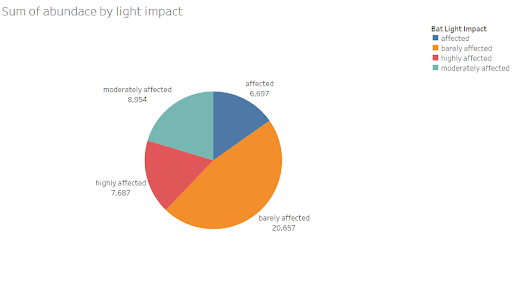

In [548]:
Image("EDA/EDA_9.png")

This pie chart shows the abundance of bats depending on how much lights affects the type of bat. We can notice that most of the bats are barely affected by light, this is cause most of them are from the Pipistrellus genus which do well in light but they are affected a bit cause they become easier prey. Whereas a fewer number are highly affected or affected by the light.

#### Trees in Ecological Areas

We found that bats like to roost in trees, and they are more likely to roost in a tree that belongs to an ecological area (https://www.bats.org.uk/about-bats/where-do-bats-live/bat-roosts/roosts-in-trees). Therefore, we decided to use a dataset that contains trees from around bristol, and filter only trees that belong to either a wildlife corridor, an ecological area classified as a site of nature conservation, or a green open space.  The dataset for trees in bristol was found in the following link: https://opendata.bristol.gov.uk/explore/dataset/trees/information/. The dataset for wildlife corridors was already provided and the the datasets for natural sites and open areas were found in the following links:  https://opendata.bristol.gov.uk/explore/dataset/sites-of-nature-conservation-interest/information/ and https://opendata.bristol.gov.uk/explore/dataset/important-open-space/map/?location=11,51.45872,-2.60825&basemap=jawg.streets

In [549]:
trees = pd.read_csv("trees.csv", sep=";")
nature_sites = pd.read_csv("sites-of-nature-conservation-interest.csv", sep=";").dropna().reset_index()
open_space = pd.read_csv("important-open-space.csv", sep=";").loc[:,["NAME","geo_shape"]].dropna()

First we are going to find the trees that belong to one of the wildlife corridors. To do this we are going to use the 'shapely' library and convert the Easting and Northing into a point type as seen in the function below. This is done because the wildlife corridors and natural conservation sites datasets contain polygon and multipolygon geometries which can be used to find whether a tree is inside one of this.

In [550]:
def to_point(Easting, Northing):  # function takes a list of Eastings and Northings (can also be longitude and latitude)
    points = []
    for i in range(0, len(Easting)):
        point = Point(Easting[i], Northing[i])  # using shapely function to convert to Point type
        points.append(point)
    return points

In [551]:
# creting a new column with all the points
trees["point"] = to_point(trees.x, trees.y)

In [552]:
# applying the shapely wkt.loads function to convert the geometries (given as strings) to polygon types
wc['geometry_conversion'] = wc.geometry.apply(wkt.loads)

Now that we have converted the points and polygons into shapely geometries we can build a function to determine whether a tree is inside a wildlife corridor. The function below takes a single point, and a list of polygons to 'search_in' and determines whether that point is inside any of those polygons. The 'which' parameter has been added as a functionality to determine the position of the polygon it is located in inside the list of polygons. This functionality will be used later.

In [553]:
def finder(point, search_in, which=False):
    inside = []

    for polygon in search_in:
        inside.append(
            point.within(polygon))  # using method of point type to determine if its inside a specified polygon

    for i in range(len(inside)):  # finding position of the polygon it is inside
        if inside[i] == True:
            position = i
    if which == True:
        return position
    else:
        return any(inside)  # finding if the point is inside 1 of the polygons

In [554]:
# applying function to check which trees are inside a wildlife corridor
trees["in_wildlife_corridor"] = trees.point.apply(finder, search_in=wc.geometry_conversion)

In [555]:
trees.in_wildlife_corridor.value_counts()

False    38143
True      9937
Name: in_wildlife_corridor, dtype: int64

We can see that out of the 48,080 trees there are 9937 trees inside a wildlife corridor. Now we are going to check the trees that are inside a natural site and open space. The geometries in this datasets were not written in the same way as those in the wildlife corridors dataset, this means we couldn't just apply the wkt.loads function. We needed to create a new one. Another difference in the datasets is that the wildlife corridor geometries are written with eastings and northings but the nature sites and open space geometries are written with longitudes and latitudes. Fortunately, the column 'geo_shape' in the trees dataset is is in longitude and latitude and because this column is also a string with a dictionary inside we can use the function we are going to create to convert that column into a shapely point type.

In [556]:
def to_geometry(geo_shape):
    geo_dictionary = literal_eval(geo_shape)  #changing the string with a dictionary inside to an actual dictionary
    type = geo_dictionary["type"]  # determining the type of geometry in order to apply the correct shapely function
    if type == "Polygon":
        return Polygon(shape(geo_dictionary))
    elif type == "MultiPolygon":
        return MultiPolygon(shape(geo_dictionary))
    elif type == "Point":
        return Point(shape(geo_dictionary))

In [557]:
# applying the to_geometry function to create a new column in the three datasets
nature_sites["geometry_conversion"] = nature_sites.geo_shape.apply(to_geometry)
open_space["geometry_conversion"] = open_space.geo_shape.apply(to_geometry)
trees["point_lonlat"] = trees.geo_shape.apply(to_geometry)

In [558]:
# determining which trees are inside one of the natural sites or open spaces
trees["in_natural_site"] = trees.point_lonlat.apply(finder, search_in=nature_sites.geometry_conversion)
trees["in_open_space"] = trees.point_lonlat.apply(finder, search_in=open_space.geometry_conversion)

In [559]:
trees.in_natural_site.value_counts()

False    42646
True      5434
Name: in_natural_site, dtype: int64

In [560]:
trees.in_open_space.value_counts()

False    27408
True     20672
Name: in_open_space, dtype: int64

There are 5434 trees that are inside one of the natural conservation sites and 20672 are inside and open space. Now we have to check whether the trees are in either of these three (to not count duplicates) and simply determine if the tree is inside an ecological area.

In [561]:
def in_eco_area(in_wc, in_ns, in_os):
    in_eco_area = []
    for i in range(len(in_wc)):
        in_eco_area.append(any([in_wc[i], in_ns[i], in_os[i]]))

    return in_eco_area

In [562]:
trees["in_eco_area"] = in_eco_area(trees.in_wildlife_corridor, trees.in_natural_site, trees.in_open_space)

In [563]:
trees.in_eco_area.value_counts()

False    24468
True     23612
Name: in_eco_area, dtype: int64

We can see that there are 23,612 trees in an ecological area. Last thing missing is to add the grid reference for the trees and select only those that are in an ecological are. This is done in the lines below.

In [564]:
trees['GRID_REF'] = pd.read_csv("trees_grids.txt", header=None).iloc[:,
                    3]  # grid references obtained with the website mentioned before
trees.GRID_REF = trees.GRID_REF.apply(grid)

In [565]:
eco_trees = trees.loc[trees.in_eco_area == True, :]

#### Traffic Accidents

As our optimization algorithm has to find the best light configuration while taking into account the bats and the safety for the cars and pedestrians, we decided to incorporate two datasets that will be used to determine how safe a particular grid reference is. One of these is a traffic accidents dataset which contains records for traffic accidents in Bristol. This dataset was found in the following link: https://opendata.bristol.gov.uk/explore/dataset/traffic-accidents0/information/. The other dataset (which will be used in the next section) is the crime dataset which can be found in the following link: https://opendata.bristol.gov.uk/explore/?refine.theme=Safety&sort=modified. We believe that the number of traffic accidents and the crime index in a particular grid will give a good indication of how reccomendable it is to turn off the lights at night. For the traffic accidents dataset the only manipulation that had to be done was add the grid reference, which once again was done with the website provided.

In [566]:
accidents = pd.read_csv("traffic-accidents0.csv", sep=";")
accidents['GRID_REF'] = pd.read_csv("accidents_grid.txt", header=None).iloc[:, 3]
accidents.GRID_REF = accidents.GRID_REF.apply(grid)

#### Crime in Bristol

The crime dataset was filtered to only include crime rates from the 2021/22 period. We needed to remove that row that contained the crime rate for the whole of Bristol in order to continue with the data processing.

In [567]:
crimes = pd.read_csv("crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward.csv", sep=";")
crimes = crimes.loc[(crimes["Time Period"] == "2021/22") & (crimes["Ward Name "] != "Bristol"), :].reset_index()

# converting the geometries of each Ward into shapely polygons to later find within which ward a grid reference is located
crimes["geometry_conversion"] = crimes.geo_shape.apply(to_geometry)

We need to classify in which Ward a grid reference is. To do this we are going to use the middle of the grid reference of the distinct grid references that can be found in the lights dataset and convert them to longitude and latitude using the tool that was previously used to convert from longitude and latitude to grid reference. Then we will check in which ward this point is located it. This way we can assign a danger level on each grid reference based on how dangerous its corresponding Ward is.

NOTE: One of the major limitations of this dataset is that it only containes information by Ward. If we would have access to a similar dataset that gives information about crime on more specific areas rather than the whole ward then we would have a better representation of the crime levels on each grid reference.

As mentioned before the we are going to find the midpoint of each grid in order to find the latitude and longitude and use this point to find inside of which ward a grid reference is.

In [568]:
def midpoint_grid(grid):
    return grid[0:5] + "50" + grid[-3:] + "50"  # finding the midpoint

In [569]:
# applying the midpoint_grid function to the distinct grid references that can be found in the street lights dataset
grid_references = pd.Series(lights.GRID_REF.unique()).apply(midpoint_grid)
grid_references.to_csv("grids.txt")

In [570]:
# finding the latitude and longitudes to later apply the to_point function
latitude = pd.read_csv("grids_lonlat.txt", header=None).iloc[:, 4]
longitude = pd.read_csv("grids_lonlat.txt", header=None).iloc[:, 5]

In [571]:
grid_references = pd.DataFrame({'GRID_REF': lights.GRID_REF.unique(), "latitude": latitude, "longitude": longitude})
grid_references["point"] = to_point(grid_references.longitude, grid_references.latitude)

The function 'which_ward' below will take the midpoint of a grid reference and determine in which ward it is located. As can be seen this function uses the 'finder' function created before and now uses the 'which' parameter as this will help us determine (based on the lists of ward names and ward geometries) in which ward the point is located in.

In [572]:
def which_ward(point, ward_names, geometries):
    for i in range(len(ward_names)):
        if finder(point, geometries):
            return ward_names[finder(point, geometries, which=True)]

In [573]:
# applying the 'which_ward' function to the distinct grid references
grid_references["Ward"] = grid_references.point.apply(which_ward, ward_names=crimes["Ward Name "],
                                                      geometries=crimes.geometry_conversion)

# some of the grid references didn't belong to any of the wards. This point were classified as 'Outside Bristol'
grid_references.Ward[grid_references.Ward.isnull()] = "Outside Bristol"

We are going to create a very simple crime index that will be easier for us to use once we are developing the fitness function. We are going to take the crimes per 1000 people in each ward and divide it by the same measure but for the whole of bristol. That way the crime index will tell us how many times more dangeorus a city is compared to the average of Bristol.

In [574]:
# obtaining the crime rate for the whole of bristol in the 2021/22 period
bristol_crime_rate = pd.read_csv("crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward.csv", sep=";")
bristol_crime_rate = bristol_crime_rate.loc[
                     (bristol_crime_rate["Time Period"] == "2021/22") & (bristol_crime_rate["Ward Name "] == "Bristol"),
                     :]
bristol_crime_rate = float(bristol_crime_rate["All Crimes (rate per 1000 ward population)"])

In [575]:
# creating the crime index
crimes["crime_index"] = crimes["All Crimes (rate per 1000 ward population)"] / bristol_crime_rate
crimes = crimes.loc[:, ["Ward Name ", "crime_index"]]

# as there is no crime rate for 'Outside Bristol' we are just going to assume that it is the same as the average of bristol, thus we assign 1
outside_bristol = pd.DataFrame({"Ward Name ": ["Outside Bristol"], "crime_index": 1})
crimes = pd.concat([crimes, outside_bristol]).reset_index(drop=True)

In [576]:
# merging grid references and crimes to obtain the grid reference, ward, and crime index for each grid reference
grid_references = grid_references.merge(crimes, how="left", left_on="Ward", right_on="Ward Name ").drop(
    ["Ward Name ", "latitude", "longitude"], axis=1)

In [577]:
grid_references

GRID_REF                         point                         Ward  \
0     ST616734    POINT (-2.55337 51.458719)               St George West   
1     ST602739  POINT (-2.5735758 51.463117)                Lawrence Hill   
2     ST602740   POINT (-2.573587 51.464016)                Lawrence Hill   
3     ST600737  POINT (-2.5764319 51.461305)                Lawrence Hill   
4     ST601738  POINT (-2.5750038 51.462211)                Lawrence Hill   
...        ...                           ...                          ...   
7500  ST620737  POINT (-2.5476453 51.461443)               St George West   
7501  ST620736  POINT (-2.5476345 51.460544)               St George West   
7502  ST621736  POINT (-2.5461952 51.460551)               St George West   
7503  ST577767  POINT (-2.6098959 51.488111)  Westbury-on-Trym & Henleaze   
7504  ST567680  POINT (-2.6232311 51.409813)       Hartcliffe & Withywood   

      crime_index  
0        0.974289  
1        1.634323  
2        1.634323  
3        1.634323  
4        1.634323  
...           ...  
7500     0.974289  
7501     0.974289  
7502     0.974289  
7503     0.372855  
7504     1.202807  

[7505 rows x 4 columns]

#### Putting everything together

We now need to join all the datasets into a single one so we can use for the optimization algorithms. The idea is to create a dataset in which we have the information on each unique grid reference.

In [578]:
lamp_type_counts = lights.groupby(["GRID_REF", "lamp_type"]).agg({"lamp_type": "count"}).rename(
    columns={"lamp_type": "count"}).reset_index()
bat_counts = bats.groupby(["GRID_REF", "bat_light_impact"]).agg({"ABUNDANCE": "sum"}).reset_index()

In [579]:
lamp_type_counts.head()

GRID_REF     lamp_type  count
0  ST513781  Metal halide      1
1  ST513782  Metal halide      6
2  ST513782           SOX      2
3  ST513783           LED      1
4  ST513783  Metal halide      1

For the bats and lights we want to have each of the types of light as a separate column and how each bat is affected by light each as separate columns as well. The function below will help us turn the datasets above into the format we desire.

In [580]:
def create_grid_columns(count_df, which):
    grids = count_df["GRID_REF"].unique()
    if which == "lights":
        final_df = pd.DataFrame(
            {"GRID_REF": [], "Metal_halide": [], "LED": [], "SON": [], "SOX": [],
             "Other": []})  # this will help us put everything together in the end
        for i in range(len(grids)):  # we will run this loop for each grid to find the abundance of each type  of lamp
            grid_ref = grids[i]
            grid_df = count_df.loc[count_df["GRID_REF"] == grid_ref, :]  # creating a dataframe for that particular grid

            # we set each value equal to 0 to avoid getting null values in the cases were some of the types of lamp are not present
            metal_halide = 0
            LED = 0
            SON = 0
            SOX = 0
            other = 0

            for i in range(
                    grid_df.shape[0]):  # this loop will give us the values that we are looking for for each lamp type
                if grid_df.iloc[i, 1] == "Metal halide":
                    metal_halide = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "LED":
                    LED = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "SON":
                    SON = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "SOX":
                    SOX = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "Other":
                    other = grid_df.iloc[i, 2]

            df = pd.DataFrame(
                {"GRID_REF": grid_ref, "Metal_halide": metal_halide, "LED": LED, "SON": SON, "SOX": SOX,
                 "Other": other}, index=[0])  # creating a row for a specific grid for the final_df
            final_df = pd.concat([final_df, df]).reset_index(drop=True)  # adding the row for the specific grid

        return final_df

    elif which == "bats":
        final_df = pd.DataFrame(
            {"GRID_REF": [], "highly_affected_bats": [], "affected_bats": [], "moderately_affected_bats": [],
             "barely_affected_bats": []})
        for i in range(len(grids)):  # we will run this loop for each grid to find the abundance of each type  of bat
            grid_ref = grids[i]
            grid_df = count_df.loc[count_df["GRID_REF"] == grid_ref, :]

            # we set each value equal to 0 to avoid getting null values in the cases were some of the types of bat are not present
            highly_affected = 0
            affected = 0
            moderately_affected = 0
            barely_affected = 0

            for i in range(
                    grid_df.shape[0]):  # this loop will give us the values that we are looking for for each bat type
                if grid_df.iloc[i, 1] == "highly affected":
                    highly_affected = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "affected":
                    affected = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "moderately affected":
                    moderately_affected = grid_df.iloc[i, 2]
                elif grid_df.iloc[i, 1] == "barely affected":
                    barely_affected = grid_df.iloc[i, 2]

            df = pd.DataFrame(
                {"GRID_REF": grid_ref, "highly_affected_bats": highly_affected, "affected_bats": affected,
                 "moderately_affected_bats": moderately_affected, "barely_affected_bats": barely_affected}, index=[0])
            final_df = pd.concat([final_df, df]).reset_index(drop=True)

        return final_df

In [581]:
# using the function that was create to put the dataset in the desired format
light_grid = create_grid_columns(lamp_type_counts, which="lights")
bat_grid = create_grid_columns(bat_counts, which="bats")

For the rest we can just group by grid reference and either count or sum. This is done for the rest of the datasets in the code below.

In [582]:
#moths dataset
moth_grid = moths.groupby("GRID_REF").agg({"Abundance": "sum"}).rename(columns={"Abundance": "moths"}).reset_index()

# trees dataset
eco_tree_grid = eco_trees.groupby("GRID_REF").agg({"GRID_REF": "count"}).rename(
    columns={"GRID_REF": "eco_trees"}).reset_index()

# traffic accidents dataset
accidents = accidents.groupby("GRID_REF").agg({"GRID_REF": "count"}).rename(
    columns={"GRID_REF": "traffic_accidents"}).reset_index()

We now merge all the datasets with the grid_references dataset created before (this dataset already contains the information for the crime index).

In [583]:
datasets = [light_grid, bat_grid, moth_grid, eco_tree_grid, accidents]  # list with datasets to merge

# merging all of them by grid reference
for i in range(len(datasets)):
    grid_references = grid_references.merge(datasets[i], how="left", on="GRID_REF").fillna(0)  # some grid references contain no information in some of the datasets

In [584]:
grid_references.head()

GRID_REF                         point            Ward  crime_index  \
0  ST616734    POINT (-2.55337 51.458719)  St George West     0.974289   
1  ST602739  POINT (-2.5735758 51.463117)   Lawrence Hill     1.634323   
2  ST602740   POINT (-2.573587 51.464016)   Lawrence Hill     1.634323   
3  ST600737  POINT (-2.5764319 51.461305)   Lawrence Hill     1.634323   
4  ST601738  POINT (-2.5750038 51.462211)   Lawrence Hill     1.634323   

   Metal_halide  LED  SON  SOX  Other  highly_affected_bats  affected_bats  \
0           4.0  3.0  0.0  0.0    0.0                   0.0            0.0   
1           8.0  8.0  1.0  0.0    0.0                   0.0            0.0   
2           7.0  3.0  0.0  0.0    0.0                   0.0            0.0   
3           7.0  2.0  0.0  0.0    0.0                   0.0            0.0   
4           7.0  8.0  0.0  0.0    0.0                   0.0            0.0   

   moderately_affected_bats  barely_affected_bats  moths  eco_trees  \
0                       0.0                   0.0    0.0        2.0   
1                       0.0                   0.0    0.0        1.0   
2                       0.0                   0.0    0.0        0.0   
3                       0.0                   0.0    0.0        0.0   
4                       0.0                   0.0    0.0        0.0   

   traffic_accidents  
0                1.0  
1                0.0  
2                0.0  
3                2.0  
4                0.0

For our algorithm, we want to focus on the grids that have bats. Because the surrounding area is also important to keep in mind when choosing the optimal places to turn off the lights, we will also take into account neighbouring grid references and their light configuration. If we look at the grid below we can see that as the grids are 100m x 100m, and we can't simply assume that all bats are in the middle. If there was a concentration of bats in a border like in the point shown in black below, then nearby lights coming from a neighboring grid, as seen in the diagram, would definitely affect the bats as well. We are going to assume that the light configurations beyond the neighboring grids (which are eight) do not affect a grid that has bats. Therefore, in the following lines we find all grids with bats and all of it's the corresponding neighbors.

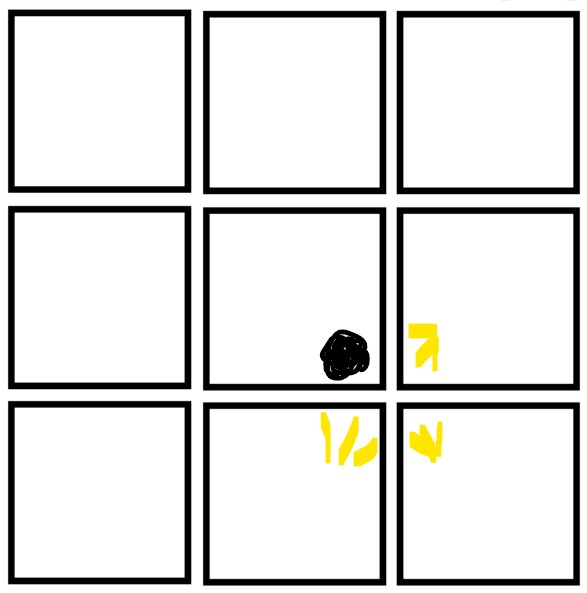

In [585]:
Image("neighbors.jpg")

In [586]:
# obtaining all grids that have at least one bat
grids_bats = grid_references.loc[(grid_references.iloc[:, 9] != 0) | (grid_references.iloc[:, 10] != 0) | (
        grid_references.iloc[:, 11] != 0) | (grid_references.iloc[:, 12] != 0), :].GRID_REF.reset_index(drop=True)

If, for instance, we wanted to find the grid on top of 'ST567734' we would have to break it down into its components(zone:ST, easting: 567, northing: 734) and add one unit to the northing component, thus we would get the following grid reference: 'ST567735'. The function below will do this process to find each of the 8 neighboring grids.

In [587]:
def find_neighbors(grid):
    jumps = [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]]  # sets of jumps to find neighbors
    neighbors = []
    neighbors.append(grid)
    for i in range(len(jumps)):  # looping for each jump
        neighbors.append(grid[0:2] + str(int(grid[2:5]) + jumps[i][0]) + str(
            int(grid[-3:]) + jumps[i][1]))  # creating the neighboring grid

    return neighbors

In [588]:
# now we find all neighboring grids for the grids were bats have been observed
lists_neighbors = grids_bats.apply(find_neighbors)  # list of lists with each bat grid and its neighbors as per list
all_neighbors = []

for neighbors in lists_neighbors:  # finding every grid reference that either is a bat grid or a neighbor
    for neighbor in neighbors:
        all_neighbors.append(neighbor)

grids_bats_neighbors = pd.DataFrame(pd.Series(all_neighbors).unique()).rename(columns={0: "GRID_REF"})
print("There are {} grids with bats or neighbors out of the {} total grid references".format(
    *[len(grids_bats_neighbors), len(grid_references)]))

There are 1574 grids with bats or neighbors out of the 7505 total grid references


The rest of the grids will automatically be assigned as turned on for the hibernation algorithm as we are going to assume that if there are lights anywhere beyond the neighbors it won't affect the bats

We will build two algorithms, one for when bats hibernate and theoretically are not moving around and another one for summer, where they need to fly to different locations to feed themselves.

### Preparing Data for Hibernation Period

#### Creating the dataframe for the hibernation optimization algorithm

For this algorithm we won't consider all 7505 grids that contain streetlights instead we will only use those that have bats and its neighbors. Therefore, we merge the datasets so that we are only left to decide which light configuration is best for the bat and its neighbors. The rest of the grids will, in the end, be left with the lights on because, as mentioned before, we assume that any grids beyond the neighbors are not going to affect the bats.

In [589]:
opt_df1 = grid_references.merge(grids_bats_neighbors, how="right", on="GRID_REF").fillna(0)
opt_df1.iloc[6,:]

GRID_REF                    ST566732
point                              0
Ward                               0
crime_index                      0.0
Metal_halide                     0.0
LED                              0.0
SON                              0.0
SOX                              0.0
Other                            0.0
highly_affected_bats             0.0
affected_bats                    0.0
moderately_affected_bats         0.0
barely_affected_bats             0.0
moths                            0.0
eco_trees                        0.0
traffic_accidents                0.0
Name: 6, dtype: object

As can be seen in the row with index 6, all of its values equal 0 except for the grid reference column. There are several rows that have the same problem. This problem happens because many of the neighboring grids that were found were not in any of the datasets. The only column that we care about changing and fixing is the crime index as the rest are 0 anyways. To obtain the crime index for the grids with no street lights we are going to separate the dataframe to later join it once we have obtained the crime index for the grids with no street lights.

In [590]:
# to obtain the crime index for the grids with no street lights we first need obtain only those
no_light_df = opt_df1.loc[opt_df1.crime_index == 0, :].drop(["crime_index"],axis=1)
light_df = opt_df1.loc[opt_df1.crime_index != 0, :]

In [591]:
# export grids to convert to longitude and latitude
no_light_df.GRID_REF.apply(midpoint_grid).to_csv("dark_grids.txt")

In [592]:
# finding the latitude and longitudes
latitude = pd.read_csv("dark_grids_lonlat.txt", header=None).iloc[:, 4]
longitude = pd.read_csv("dark_grids_lonlat.txt", header=None).iloc[:, 5]

# applying the to_point function
no_light_df["point"] = to_point(longitude, latitude)

# obtaining crimes dataset
crimes = pd.read_csv("crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward.csv", sep=";")
crimes = crimes.loc[(crimes["Time Period"] == "2021/22") & (crimes["Ward Name "] != "Bristol"), :].reset_index()
crimes["geometry_conversion"] = crimes.geo_shape.apply(to_geometry)

# finding which ward the grid references belong in
no_light_df["Ward"] = no_light_df.point.apply(which_ward, ward_names=crimes["Ward Name "],
                                                      geometries=crimes.geometry_conversion)

# creating the crime index
crimes["crime_index"] = crimes["All Crimes (rate per 1000 ward population)"] / bristol_crime_rate
crimes2 = crimes.loc[:, ["Ward Name ", "crime_index", "geometry_conversion"]]

# as there is no crime rate for 'Outside Bristol' we are just going to assume that it is the same as the average of bristol, thus we assign 1
outside_bristol = pd.DataFrame({"Ward Name ": ["Outside Bristol"], "crime_index": 1})
crimes2 = pd.concat([crimes2, outside_bristol]).reset_index(drop=True)

# some of the grid references didn't belong to any of the wards. This point were classified as 'Outside Bristol'
no_light_df.Ward[no_light_df.Ward.isnull()] = "Outside Bristol"

# merging grid references and crimes to obtain the grid reference, ward, and crime index for each grid reference
no_light_df = no_light_df.merge(crimes2, how="left", left_on="Ward", right_on="Ward Name ").drop(
    ["Ward Name "], axis=1)

# placing columns in same column as 'light_df' to be able to concatenate
no_light_df = no_light_df.iloc[:,[0,1,2,15,3,4,5,6,7,8,9,10,11,12,13,14]]
opt_df1 = pd.concat([light_df, no_light_df]).reset_index(drop=True)

For this algorithm in the end we decided not to take into account the moths because during hibernation there is no feeding, thus, we drop it from the optimization dataframe. Point and ward won't be used either.

In [593]:
opt_df1 = opt_df1.drop(["moths", "point", "Ward"], axis=1)

When the bats hibernate they don't move around, thus, because most research is on how light affects different types of bats differently when they are moving around, we are going to assume that all bats are disturbed by light during hibernation. Moreover, we also realized after doing research that it would be very hard to quantify how each type of lamp affects the bats so we are just going to take the count for all types instead. We could't extract accurate levels of luminance from the types of lamp either and this is something that would definetly be taken into account to build a more accurate and representative algorithm if the information was available.

As we are going to have to build a score that calculates if a light configuration of a grid is friendly for bats and a score for the safety of pedestrians and drivers it didn't really make sense to use the actual numbers of each of the different variables we are going to use for these scores. Instead we wanted to build a score that could range only from 0 to 1, this will also make assigning weights easier. To achieve this we decided to use a Min Max scaler which will assign each value in a column a number from 0 to 1 based on the maximum and minimum of that column. However, first we wanted to check the distributions to check whether they are extremely right skewed as this could play a big factor in an algorithm as it could neglect some zones where there are bats but there is just significantly less than in the place with the most bats.

#### Histograms of each variable

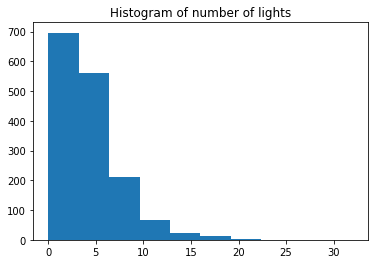

In [594]:
# first we count how many lights in each grid
number_lights = 0
for i in range(2, 7): # 2-6 are the positions of the lamp type columns
    number_lights += opt_df1.iloc[:, i]

plt.hist(number_lights)
plt.title("Histogram of number of lights")
plt.show();

We can see that the light abundance is right skewed but it is not extreme and therefore we will take the values as they appear.

In [595]:
# applying Min Max scaler on the number of lights
opt_df1["light_abundance"] = MinMaxScaler().fit_transform(np.array(number_lights).reshape(-1, 1))
opt_df1 = opt_df1.drop(["Metal_halide", "LED", "SON", "SOX", "Other"], axis=1)

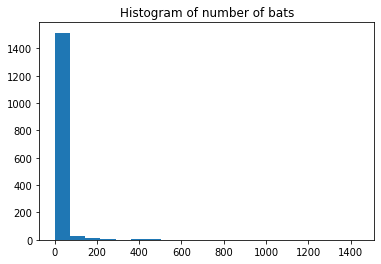

In [596]:
# first we count how many bats in each grid
number_bats = 0
for i in range(2, 6): # 2-5 are the positions of the bat type columns
    number_bats += opt_df1.iloc[:, i]

plt.hist(number_bats, bins=20)
plt.title("Histogram of number of bats")
plt.show();

For the bats distribution we can see there is an extreme right-skewness, therefore we are going to apply the log in order to counteract the skewness. The new distribution would look like the one below.

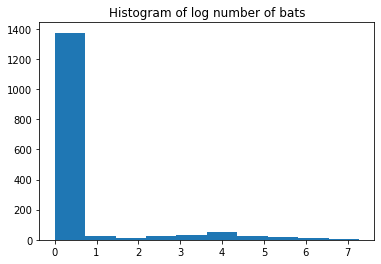

In [597]:
# we must add 1 because else we would have the values that equal 0 turned into -Inf
plt.hist(np.log(number_bats + 1))
plt.title("Histogram of log number of bats")
plt.show();

We can see there is still right-skewness because most values equal 0, but it is significantly reduced. Thus we will use the log of the number of bats for the bat abundance.

In [598]:
# applying Min Max scaler on the number of bats
opt_df1["bat_abundance"] = MinMaxScaler().fit_transform(np.log(np.array(number_bats)+1).reshape(-1, 1))
opt_df1 = opt_df1.drop(
    ["highly_affected_bats", "affected_bats", "moderately_affected_bats", "barely_affected_bats"], axis=1)

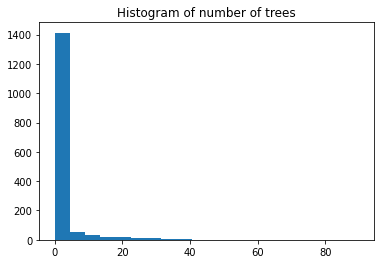

In [599]:
plt.hist(opt_df1.eco_trees, bins=20)
plt.title("Histogram of number of trees")
plt.show();

We can see a strong right-skewness, thus we will apply the log.

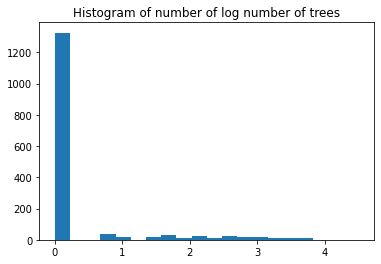

In [600]:
# we must add 1 because else we would have the values that equal 0 turned into -Inf
plt.hist(np.log(opt_df1.eco_trees + 1), bins=20)
plt.title("Histogram of number of log number of trees")
plt.show();

We can see an improvement so we will use the log number of trees for the trees abundance

In [601]:
# applying Min Max scaler on the number of trees
opt_df1["trees_abundance"] = MinMaxScaler().fit_transform(
    np.array(opt_df1.eco_trees).reshape(-1, 1))
opt_df1 = opt_df1.drop(["eco_trees"], axis=1)

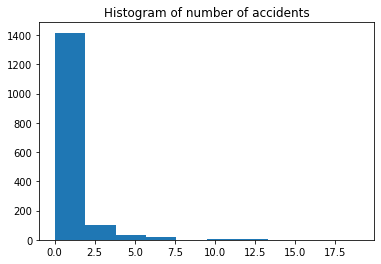

In [602]:
plt.hist(opt_df1.traffic_accidents)
plt.title("Histogram of number of accidents")
plt.show();

There is right skewness but the values are small so it is best to keep them as they are.

In [603]:
# applying Min Max scaler on the number of accidents
opt_df1["accidents_abundance"] = 1- MinMaxScaler().fit_transform(
    np.array(opt_df1.traffic_accidents).reshape(-1, 1)) # we do 1 - MinMaxScaler because we want a higher score to mean it is less likely for an accident to happen
opt_df1 = opt_df1.drop(["traffic_accidents"], axis=1)

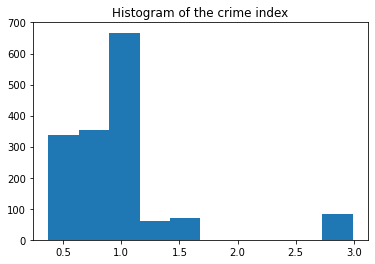

In [604]:
plt.hist(opt_df1.crime_index)
plt.title("Histogram of the crime index")
plt.show();

We will leave the crime index as it is.

In [605]:
# applying Min Max scaler on the crime index
opt_df1["crime_index_scaled"] = 1 - MinMaxScaler().fit_transform(
    np.array(opt_df1.crime_index).reshape(-1, 1))  # we do 1 - MinMaxScaler because we want a higher score to mean it is safer
opt_df1 = opt_df1.drop(["crime_index"], axis=1)

For our optimization algorithm the domain will be the possible light configurations that a particular grid reference can have. We have to remember that some of the grids that are found in the neighbors of the bat grids had no records of any street light. Therefore, the only configuration possible is for the grid to be dark. We are going to assign a 0 as dark/lights off and 1 as lights turned on.

In [606]:
# filtering grids that have no street lights
no_light_df = opt_df1.loc[opt_df1.light_abundance == 0, :]
# creating the possible light configurations, in this case each row will have the list: [0] as this grids can only be dark
no_light_df["light_configs"] = [[*range(1)] for _ in range(no_light_df.shape[0])]

# filtering grids that do have street lights
light_df = opt_df1.loc[opt_df1.light_abundance != 0, :]
# creating the possible light configurations, in this case each row will have the list: [0,1] as the light can be on or off
light_df['light_configs'] = [[*range(2)] for _ in range(light_df.shape[0])]

# joining both dataframes
opt_df1 = pd.concat([light_df, no_light_df]).reset_index(drop=True)
opt_df1.head()

GRID_REF  light_abundance  bat_abundance  trees_abundance  \
0  ST567733          0.28125       0.748295         0.100000   
1  ST567734          0.06250       0.000000         0.000000   
2  ST568734          0.09375       0.000000         0.000000   
3  ST568733          0.25000       0.000000         0.255556   
4  ST568732          0.28125       0.000000         0.400000   

   accidents_abundance  crime_index_scaled light_configs  
0             0.947368            0.954355        [0, 1]  
1             1.000000            0.954355        [0, 1]  
2             1.000000            0.954355        [0, 1]  
3             1.000000            0.954355        [0, 1]  
4             1.000000            0.954355        [0, 1]

### Creating the scores for the hibernation period

We are going to create two scores that we want to try and maximize to determine which lights should be turned off during hybernation (winter). In this case we don't care about how lights affects how they move around, the important thing is to not disturb them with lights while they hybernate.

Bat Friendly Score: This score will take into consideration the total number of bats, the number of lights, the number of trees in ecological areas, and the light configuration of the neighboring grids.
Safety Score: This score take into account the number of lights, number of traffic accidents, crime index and neighbors.

#### Creating Bat Friendly Score

The bat friendly score will be calculated just for the bat grids but as mentioned before it will take into account the neighboring grids. The function that will calculate the score will receive as input a list with the bat grid as the first element and the rest of elements being the neighbors and the light configurations for the 9 grids. An example of this two is: ['ST567733', 'ST567734', 'ST568734', 'ST568733', 'ST568732', 'ST567732', 'ST566732', 'ST566733', 'ST566734'] for the grids and [1,0,1,1,0,0,1,1,0] for the light configurations.

As previously mentioned this score will take into consideration the bat abundance, the abundance of lights, the abundance of trees in ecological areas and the light configuration of the neighboring grids.

In [607]:
def bat_friendly_score(grids_bat_and_neighbors, light_configs):
    main_grid = grids_bat_and_neighbors[0] # obtaining the bat grid
    neighbors_light_scores = []
    neighbors_df = opt_df1.set_index("GRID_REF").loc[grids_bat_and_neighbors, :]

    for i in range(1, len(grids_bat_and_neighbors)): # obtaining the light score for all the neighboring grids
        light_config = light_configs[i]
        if light_config == 0:
            light_score = 1
        else:
            # we take 1 - light abundance because the more lights the worse for bats so the score should be lower
            light_score = 1 - neighbors_df.light_abundance.loc[
                neighbors_df.index == grids_bat_and_neighbors[i]].reset_index(drop=True)[0]

        neighbors_light_scores.append(light_score)

    # the neighbor score is just the mean of the light score for all of the neighbors
    neighbors_score = np.mean(neighbors_light_scores)

    # btaining the light score for the bat grid
    if light_configs[0] == 0:
        light_score = 1
    else: # we take 1 - light_abundance because we want that the higher the score is, the better it is for bats
        light_score = 1 - neighbors_df.light_abundance.loc[neighbors_df.index == main_grid].reset_index(drop=True)[0]

    # Obtaining the bat score for the bat grid
    bat_score = neighbors_df.bat_abundance.loc[neighbors_df.index == main_grid].reset_index(drop=True)[0]

    # btaining the tree score for the bat grid (the higher the more likely it is for there to be a roost)
    tree_score = neighbors_df.trees_abundance.loc[neighbors_df.index == main_grid].reset_index(drop=True)[0]

    # calculating the bat friendly score and applying weights to each of the variables
    bat_friendly_score = 0.25*bat_score + 0.3 * light_score * bat_score + 0.15 * tree_score * light_score + 0.3 * neighbors_score * bat_score

    return bat_friendly_score

The weights are based on what we believed made the most sense. We have three interactions that are light dependent (light_score * bat_score and neighbor_score * bat_score and tree_score*) these are the ones we considered more important. For the light_score * bat_score the logic is: if there are no lights then the light_score is 1 and if it is the grid with the most bats then the bat_score is also 1, thus, as this is the best possible scenario, when we multiply both we obtain 1, which is the maximum we can get from multiplying any of the two variables we have created. Hence, as we are trying to maximize the cost it is what makes the most sense. The same logic applies for the other two interactions. The more bats and less light in the neighbors it is better a place for the bats. The more trees and less light the better it is for the bats to hibernate. As for the bat_score, we decided to consider it individually because we believe that if there is a grid were there are a lot of bats ,even in the presence of lights, it is because there are other factors that we are not considering that make that grid a good place for bats.

We want to check if the score makes sense, therefore, what we should see is that if there is a high number of bats and a small number of lights then the score should be very high. If we see a low number of bats then the score should always be very low. Additionally, a score should always be higher if all the lights in the main grid and its neighbors are turned off as compared to when they are turned on. To check these things we created the dataset below which will allow us to check if our assumptions about how the score works are true.

In [608]:
# comparing the scores between when all the lights in main grid and neighbors are on vs off
bat_scores = pd.DataFrame(
    {"all_on": pd.Series(lists_neighbors).apply(bat_friendly_score, light_configs=[1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "all_off": pd.Series(lists_neighbors).apply(bat_friendly_score, light_configs=[0, 0, 0, 0, 0, 0, 0, 0, 0])})

In [609]:
off_is_higher = []
for i in range(bat_scores.shape[0]):
    off_is_higher.append(bat_scores.iloc[i, 1] > bat_scores.iloc[i, 0])

pd.Series(off_is_higher).value_counts()

True    226
dtype: int64

One of the assumptions that we made is that all the lights off will provide a higher score than when they are turned on. This assumption is met. Let's look at another example to make sure it makes sense. Let's look at the Grid reference that has the highest number of bats, this one will be the one where the bat abundance equals 1.

In [610]:
opt_df1.loc[opt_df1.bat_abundance == 1, :]

GRID_REF  light_abundance  bat_abundance  trees_abundance  \
230  ST601749            0.125            1.0              0.0   

     accidents_abundance  crime_index_scaled light_configs  
230                  1.0             0.73311        [0, 1]

The grid reference for this one is "ST601749" and we can actually find were this is located in our variable 'lists_neighbors' and with this we can then determine its bat friendly score.

In [611]:
position = -1
for i in range(len(lists_neighbors)):
    position += 1
    if lists_neighbors[i][0] == "ST601749":
        break

bat_scores.iloc[position, :]

all_on     0.753906
all_off    0.850000
Name: 123, dtype: float64

As expected, because the number of bats is very high, the bat friendly score, specially when all lights are turned off, is very high. As the light abundance is not that high we expected the bat friendly score for when all are turned on to be smaller when they are turned off but the difference is not expected to be very big.

#### Creating Safety Score

As mentioned before, the safety score will take into account the number of lights, number of traffic accidents, crime index and neighbors. The balance between the bat friendly score and the safety score will provide a good indication of which lights are the best to turn off.

In [612]:
def safety_score(grids_bat_and_neighbors, light_configs):
    # obtaining the optimization dataframe just from the bat grid and its neighbors
    neighbors_df = opt_df1.set_index("GRID_REF").loc[grids_bat_and_neighbors, :]
    safety_scores = []
    for i in range(len(grids_bat_and_neighbors)): # looping for each grid
        # obtaining traffic accident score for the particular grid
        accidents_score = neighbors_df.accidents_abundance.loc[neighbors_df.index == grids_bat_and_neighbors[i]].reset_index(drop=True)[0]

        # obtaining the crime index for the particular grid
        crime_index = neighbors_df.crime_index_scaled.loc[neighbors_df.index == grids_bat_and_neighbors[i]].reset_index(drop=True)[0]

        # obtaining the light score for the particular grid. in this case the light score is equal to the safety score as more light is better
        if light_configs[i] == 0:
            light_score = 0
        else:
            light_score = neighbors_df.light_abundance.loc[neighbors_df.index == grids_bat_and_neighbors[i]].reset_index(drop=True)[0]
        raw_safety_score = 0.2 * accidents_score + 0.8 * crime_index
        light_importance = 1 - raw_safety_score

        safety_scores.append(0.5 * light_score * light_importance + 0.5 * raw_safety_score) # safety index for each grid

    return np.mean(safety_scores) # finding the mean for all grids

The safety scored is composed of the light_score * light_importance and the raw_safety_score. We considered both of this to be equally important. The interaction will vary depending on the light configurations of the neighbors and the bat grid, if light_importance is high it will be a good an indication that a better light configuration will be what maximizes the light_score. The raw_safety_score helps us also determine how safe a place is irrespective of the light configuration. Thus we combine these two to reflect and appropiate safety score for pedestrains and drivers.

In [613]:
safety_score_check = pd.DataFrame(
    {"on": pd.Series(lists_neighbors).apply(safety_score, light_configs=[1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "off": pd.Series(lists_neighbors).apply(safety_score, light_configs=[0, 0, 0, 0, 0, 0, 0, 0, 0])})

### Building the optimization algorithm for hibernation period

If we were to build an algorithm that attempted to find the best possible configuration for the light setting in the the 1574 grids and taking into account that about 250 of those can only be dark, then we would attempt to find the best solution from about 2^1300^ combinations. That is simply too many so we simplified the problem by instead first calculating the best possible configuration for each bat grid and its neighbors individually. This means that for each bat grid and its neighbors we would just be finding the best solution among a maximum of 512 (2^9^) possible light configurations for each of the 226 bat grids. Because there are very few combinations we can actually just brute force into finding the light configuration that maximizes the cost function for each bat grid.

As there are some bat grids that are neighbors of each other or have neighbors in common, there will still be some grids in which the best possible configuration can be on or off but this approach will significantly reduce the computational power needed. A genetic algorithm will be used to find the best possible configurations for the grids that have an undecided best light configuration.

In [614]:
# setting the domain and grid references
domain = opt_df1.light_configs
grid_references = opt_df1.GRID_REF

The fitness function for each bat grid is calculated by adding up the bat friendly score and the safety score. We want to maximize this value.

In [615]:
def fitness_function_single_bat_grid(neighbor_grids, solution):
    return bat_friendly_score(neighbor_grids, solution) + 2*safety_score(neighbor_grids, solution)

In order to brute force the best solutions we first need to know all the possible light configuration for each bat grid and neighbors. Below we created a function that does just that.

In [616]:
def combinations(neighbor_grids, domain):
    possible_configs = []

    # we use the domain to do this as this will determine which grids can be either on or off or if it can only be dark (grid with no streetlight)
    for neighbor in neighbor_grids:
        possible_configs.append(list(domain.loc[grid_references == neighbor])[0])

    # using the itertools product function we can obtain all the possible configurations
    return list(itertools.product(*possible_configs))

Now we create a function that will brute force through all the possible combinations to find the one that maximizes the cost function.

In [617]:
def best_solution_single_bat_grid(neighbors_grids, domain):
    possible_solutions = combinations(neighbors_grids, domain) # obtaining all possible combinations
    best_solution = possible_solutions[0] # the best solution will be updated in the for loop
    cost_best_solution = 0  # the highest cost will be updated in the for loop
    for i in range(len(possible_solutions)): # calculating the score for each combination
        cost_solution = fitness_function_single_bat_grid(neighbors_grids, possible_solutions[i])
        if cost_solution > cost_best_solution: # updating the cost and solution if a better combination is found
            best_solution = possible_solutions[i]
            cost_best_solution = cost_solution

    return best_solution

In [618]:
best_solutions = []
for i in range(len(lists_neighbors)):
    best_solutions.append(best_solution_single_bat_grid(lists_neighbors[i], domain))

Now that we have obtained the best solution for each individual grid we wan't to check which grids still have two possible light configs that could maximize the cost.

In [619]:
# creating a list of empty lists to add on to
new_domain = [[] for _ in range(len(grid_references))]

# appending the solutions found for each grid (can be more than one in some cases)
for i in range(len(lists_neighbors)):
    for j in range(len(lists_neighbors[i])):
        new_domain[int(np.where(grid_references == lists_neighbors[i][j])[0])].append(best_solutions[i][j])

new_domain = pd.Series(new_domain).apply(set).apply(list) # obtaining only the unique configurations to use as the new domain in the genetic algorithm

In [620]:
new_domain.value_counts()

[0]       901
[1]       551
[0, 1]    122
dtype: int64

We see that out of the 1547 grids in question, 122 grid still have an undecided/undetermined configuration to maximize the cost function. Brute forcing the best solution for each individual grid has reduced the problem significantly from having about 2^1300^ to 2^122^ possible combinations. Using the code below we will create a list with the indexes of the grids in which we still have an undecided light configuration. This will help us access and change this configurations to search for the best possible solution.

In [621]:
undecided_configs = []
for i in range(len(new_domain)):
    if len(new_domain[i]) == 2:
        undecided_configs.append(i)

Below we create the fitness function that will help output the cost. The cost will be what we want to maximize. The higher the cost the better the solution.

In [622]:
def fitness_function(solution):
    solution = pd.Series(solution)
    scores_bat_grids = []
    for neighbors in lists_neighbors: # we will calculate the score for each individual bat grid
        light_configs = []
        for i in range(len(neighbors)): # with this loop we obtain the light configuration for a bat grid and its neighbors (e.g. [1,0,0,0,1,0,1,1,0])
            light_configs.append(int(solution.loc[grid_references == neighbors[i]]))
        # we calculate the score for the bat grid and append it to a list of all the scores
        scores_bat_grids.append(bat_friendly_score(neighbors, light_configs) + 2* safety_score(neighbors, light_configs))

    return np.array(scores_bat_grids).sum() # the cost is the addition of all the individual bat scores

With the function below we generate a random solution using the domain that we created before. We only want to change the configurations that we are still unsure of. Therefore, the random solution generated can only vary in the 122 undecided configurations the rest will remain with the value that was determined previously.

In [623]:
def generate_random_solution(domain):
    random_solution = []
    # for each grid we take the domain (possible configurations) in some cases there will just be 1 option and in other 2 (125 undecided grids)
    for i in range(len(domain)):
        random_solution.append(random.choice(domain[i])) # we choose a random number within that domain and append it to the final list

    return random_solution

In [624]:
random_solution = generate_random_solution(new_domain)

In [625]:
t0 = time()
for i in range(10):
    f = fitness_function(random_solution)
time() - t0

17.834691524505615

The fitness function takes about 1.7 seconds to run for each solution in a regular laptop.

#### Genetic Algorithm

We decided to build a genetic algorithm that will attempt to find the optimal solution. Before creating the algorithm we needed to create a function that will create mutations and one that will create crossover.

For the mutation, what we want to do is take the 122 undecided grids (which we will refer to the genes) and change some of them. In our case we decided that the number of genes we want to change with a mutation is 12 as it is about 10% of the genes that can still change.

In [626]:
def mutation(solution, n_genes=12):
    genes = []
    mutant = solution
    for i in range(n_genes): # this loop will find n random genes from the k undecided configurations
        gene = random.choice(undecided_configs)
        genes.append(gene)
    for i in range(n_genes): # this loop will change/mutate the genes that were selected
        if mutant[genes[i]] == 0: # 0s are turned to 1s
            mutant = mutant[0:genes[i]] + [1] + mutant[genes[i] + 1:]
        else: # 1s are turned to 0s
            mutant = mutant[0:genes[i]] + [0] + mutant[genes[i] + 1:]
    return mutant

For the crossover we want to take two different solutions and create a hybrid between those two. For instance, if a solution was [1,1,1,1] and another solution was [0,0,0,0] then the crossover would take some of the first members of the first solution and mix it with some of the members of the second solution (e.g. [1,1,0,0]). However, in our case what we want to crossover is the undecided configurations as we know the rest will stay the same. To do this we created the function below.

In [627]:
def crossover(solution1, solution2):
    gene = random.randint(1, len(undecided_configs) - 2) # we choose a random number (the gene) within the length of the 'undecided_configs' list (a list of indexes)
    solution1_configs_index = undecided_configs[0:gene] # we choose the undecided configurations from 0 to the gene of solution 1
    solution2_configs_index = undecided_configs[gene:] # we choose the undecided configurations from the gene to the last of solution 2

    # we crossover the undecided configurations of both solutions
    new_configs_crossover = [solution1[i] for i in solution1_configs_index] + [solution2[i] for i in solution2_configs_index]

    crossover = solution1 # could also be solution2, doesn't matter

    for i in range(len(undecided_configs)): # we change the value of the undecided configurations to the ones of the crossover that was created
        crossover[undecided_configs[i]] = new_configs_crossover[i]

    return crossover

The genetic algorithm, as the name suggests, tries to replicate the process of natural selection by choosing only the best/strongest candidates from each 'generation' and creating mutations and crossovers between them to obtain even better candidates.

Parameters in function:
- population_size: it determines how many random solutions/individuals will be in each of the generations.
- probability_mutation: as the name suggests it is the probability that a new individual will be created through mutation instead of crossover
- elitism: the fraction of the best candidates that will remain in the next generation (if population size is 100 and elitism is 0.2, the best 20 individuals will be selected for the following generation).
- number_generations: through how many generations the algorithm will run over.

In [628]:
def genetic(domain, fitness_function, population_size=60, probability_mutation=0.25, elitism=0.2,
            number_generations=60):
    population = []
    for i in range(population_size): # creating n (population_size) random solutions
        solution = generate_random_solution(domain)
        population.append(solution)

    number_elitism = int(elitism * population_size) # defining the number of individuals that will survive each generation

    for i in range(number_generations): # calculating cost for each solution/individual
        costs = [(fitness_function(individual), individual) for individual in population] # list that contains the scores and the individuals
        costs.sort(reverse=True) # sort in them from best to worst
        ordered_individuals = [individual for (cost, individual) in costs] # selecting only the individual
        population = ordered_individuals[0:number_elitism] # selecting the best n (number_elitism) individuals from that generation
        while len(population) < population_size: # creating a new generation with mutations and crossovers. the loop runs until it reaches the desired population size
            if random.random() < probability_mutation:
                m = random.randint(0, number_elitism) # choosing random individual to mutate
                population.append(mutation(ordered_individuals[m]))
            else:
                # choosing random individuals to crossover
                i1 = random.randint(0, number_elitism)
                i2 = random.randint(0, number_elitism)
                population.append(crossover(ordered_individuals[i1], ordered_individuals[i2]))
    return costs # returning the best candidate after running the algorithm for n generations

Due to the time constraint and limitations of our computer, we couldn't run the genetic algorithm with as big a population size and  as many generations as we desired. However, we do leave the framework so that a more powerful computer can run the algorithm and obtain an excellent solution by changing the population_size and number_generations parameters.

In [629]:
optimals = genetic(new_domain, fitness_function)

In [632]:
best_solution  = optimals[0][1]

#### Optimization Algorithm Performance

We are going to see how our approach has improved and found something close to the best possible solution. We are going to compare a completely random solution, a random solution after reducing the number of possible combinations and the solution provided by the genetic algorithm. We will create a completely random solution as we already have a random solution with the reduced number of combinations and the solution found by the genetic algorithm.

In [642]:
completely_random_solution = [random.choice([0,1]) for i in range(len(light_df))] + [0 for i in range(len(no_light_df))]

In [643]:
print("completely random solution cost: {}\n random solution cost: {}\n genetic algorithm solution cost: {}".format(*[fitness_function(completely_random_solution), fitness_function(random_solution), fitness_function(best_solution)]))

completely random solution cost: 269.37801643190846
 random solution cost: 272.25607230640367
 genetic algorithm solution cost: 272.7082875650315


It seems that there is a small difference between the results but let's take a look at the distribution of the difference of the bat scores when all the lights in the bat grid and neighbors are turned off versus when they are turned on. We are iterested in this because for the bat score the maximum score for each grid will be when all lights are turned off and the minimum when all are turned on. Therefore, the difference between any other two configurations will be less than the difference of all off minus all on.

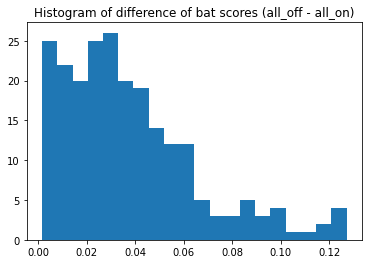

In [651]:
plt.hist(bat_scores.all_off - bat_scores.all_on, bins=20)
plt.title("Histogram of difference of bat scores (all_off - all_on)")
plt.show;

We can see that the differences are extremely small. This tells us that even a small improvement in the cost function such as an increase of 0.2 will actually lead to a significantly better solution. If we look at the distribution below, but in this case for the difference in the safety scores, we can further prove that point.

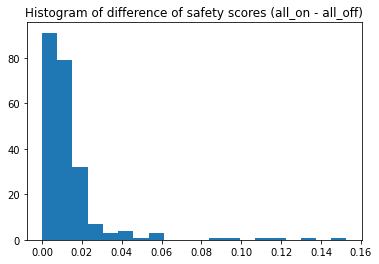

In [652]:
plt.hist(safety_score_check.on - safety_score_check.off, bins=20)
plt.title("Histogram of difference of safety scores (all_on - all_off)")
plt.show;

Hence, we can see that an improvement from a completely random solution with a cost of 269.4 to the random solution with a cost of 272.3 is a massive improvement. Moreover, the improvement of about 0.45 with the genetic algorithm is also significant but not as big of an improvement. On the one hand this is partly due because of, as mentioned before, the time restriction and the lack of a powerful computer were we  could run the genetic algorithm for many generations and with a large population size. Many generations and a large population size would lead to a very big improvement. Additionally, it could also be the case that because we reduced the number of combinations by so much, the biggest jump in improvement has already been achieved.

#### Setting the light configuration for all street lights during hibernation period

Below we create a dataset that combines the 1574 grid references with their respective light configurations.

In [223]:
hibernation_configurations = pd.DataFrame({"GRID_REF": [grid[0] for grid in grids_bats_neighbors.values.tolist()],"light_configuration":best_solution})

Now we merge this dataset with the lights dataset which contains a single street light per row. We use 'fillna(1)' because, as mentioned before, if the grid reference of a light is not one of the 1574 grids then it will automatically be classified as being turned on as it doesn't belong to a bat grid or one of its neighbors. This dataframe can be used to tell the Central Management System which lights to turn off and which one tu turn off.

In [240]:
lights_hibernation = lights.merge(hibernation_configurations, how="left", on="GRID_REF").fillna(1)

We added the latitude and longitude in order to be able to plot the image that can be seen below.

In [249]:
lights_hibernation["Latitude"] = pd.read_csv("lights_lonlat.txt", header=None).iloc[:,4]
lights_hibernation["Longitude"] = pd.read_csv("lights_lonlat.txt", header=None).iloc[:,5]
lights_hibernation.to_csv("lights_hibernation.csv")

In [686]:
lights_hibernation.light_configuration.value_counts()

1.0    34277
0.0     2622
Name: light_configuration, dtype: int64

There are 2622 street lights that should be turned off to not disturb bats during their hibernation.

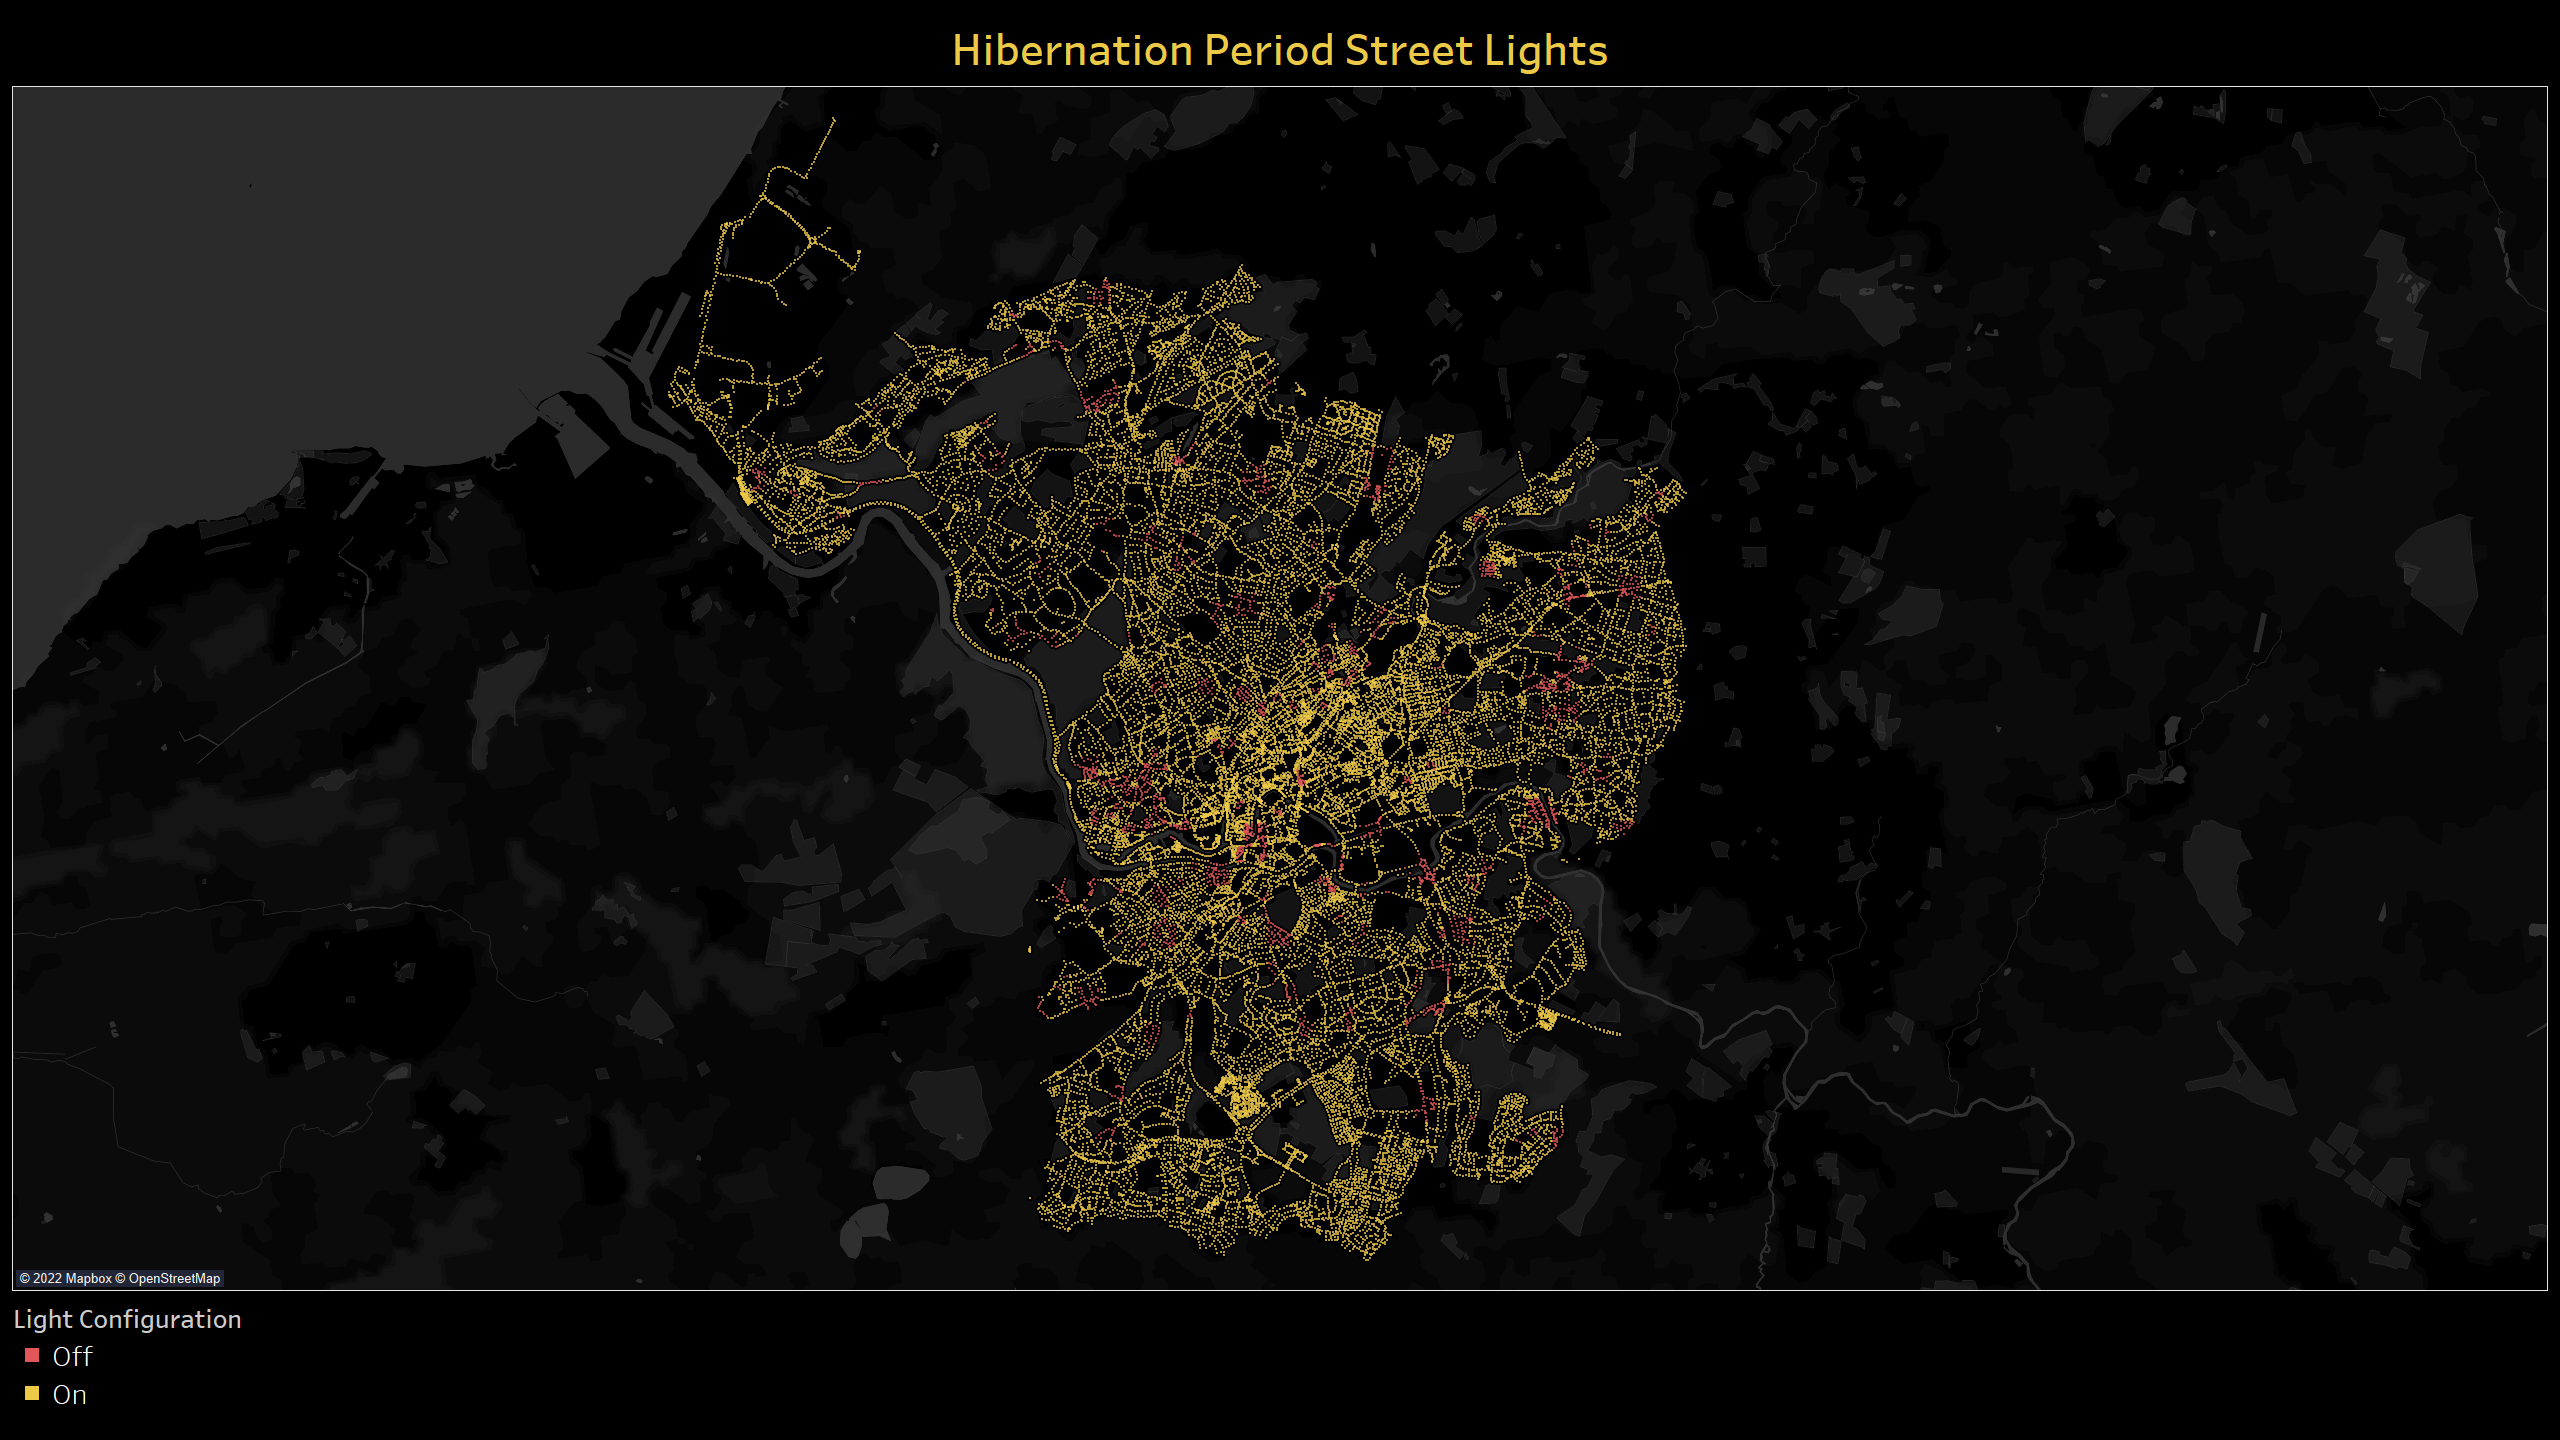

In [310]:
Image("hibernation_lights.png")

This image represents the solution that has been outputted by our optimization algorithm. It shows which lights should be turned off (red) during winter in order to not bother bats during hybernation while maintaining pedestrian and driver safety.

### Optimizing best Dark Corridors for the Feeding Period

Our idea to build the dark corridors is to not only find the shortest paths between bat grids and moth grids, but also, given that all lights will be turned off to create these paths, which path will least negatively affect the safety of pedestrians and drivers.

#### Turning grid references into geometries

To know which lights to turn off to build these paths, we need to know through which grid references the path passes through. Therefore, we need to convert the grids that contain lights into actual geometries/polygons to determine the intersections of the path with the grids. The function below does just that. If we know the grid reference we can also find the 4 points in easting and northing format that makes up the grid (square). If we take "ST571764", once again we divide it into 3 components: ST 571 764. The ST is also a code for a 100km x 100km grid and if we want to change it to an easting and northing we can do this by adding a 3 at the beginning for the easting and a 1 to the beginning of the northing. Thus, we would get (3571, 1764). Moreover, when we created the middle point of a grid reference using easting and northing we would add 2 additional digits, we will do the same to find the midpoint of bat grids and moth grids to create the path, hence, we need these polygons in the same format. Therefore, our example would become the following point (357100, 176400) and because this is the bottom left edge we can use it to find the other 3 points: (357100, 176500), (357200, 176500), (357200, 176400). With these 4 points we will be able to then create a square polygon that represents each grid and its position.

In [653]:
def find_grid_geometry(grid):
    # finding left bottom point
    easting_component = int('3' +grid[2:5] + "00")
    northing_component = int('1' + grid[5:] + "00")

    # setting the jumps to find all 4 points
    jumps = [[0,0],[0,100],[100,100],[100,0]]
    points = []

    for jump in jumps: # creating 4 shapely Points that will define the square
        point = Point(easting_component+jump[0], northing_component+jump[1])
        points.append(point)

    # building the shapely polygon using the 4 points
    return Polygon([[p.x, p.y] for p in points])

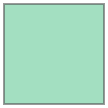

In [654]:
find_grid_geometry('ST571764')

When we try the function with the example that we talked about before we can see it does in fact create the square Polygon. We now apply the function to all the grid references that contain street lights.

In [655]:
grid_ref_shape = pd.DataFrame({"GRID_REF": lights.GRID_REF.unique(),
                               "GRID_REF_geometry":pd.Series(lights.GRID_REF.unique()).apply(find_grid_geometry),
                               "street_lights_presence": [1 for i in range(len(lights.GRID_REF.unique()))] })

#### Filtering the most abundant moth and affected bat grids

When definig where to position a dark corridor where bats can fly around during their feeding period, we only want to consider grids with a significant amount of either bats or moths as our starting/ending point for the corridor. We decided that a good value to use is 100. We also want to consider only bats that are significantly affected by light, that is why we are removing bats from the "barely affected" category as these are Pipistrellus which actually thrive more in places with light. We will sum the values in the abundance columns for both moths and bats and then only select those grids that have over 100 bats and the grids that have over 100 moths.

In [656]:
affected_bats = bats.loc[bats.bat_light_impact != "barely affected",:]
affected_bats = affected_bats.groupby(["GRID_REF"]).agg({"ABUNDANCE":"sum"}).reset_index()
abundant_moths = moths.groupby(["GRID_REF"]).agg({"Abundance":"sum"}).reset_index()

In [657]:
(affected_bats.ABUNDANCE > 100).value_counts()
affected_bats = affected_bats.loc[affected_bats.ABUNDANCE > 100,:].reset_index(drop=True)

False    285
True      60
Name: ABUNDANCE, dtype: int64

There are only 60 grids with over 100 bats.

In [658]:
(abundant_moths.Abundance > 100).value_counts()
abundant_moths = abundant_moths.loc[abundant_moths.Abundance > 100,:].reset_index(drop=True)

False    66
True     14
Name: Abundance, dtype: int64

There are only 14 grids that have over 100 moths.

#### Finding Closest moth grids

Now that we have the grids with a significant amount of bats/moths, we want to find the possibilities of connecting them together through a dark corridor. For each of the 60 bat grids, we will find the 3 closest moth grids out of the 14 possible ones and create a straight line connecting them. Those lines will define the possible paths that our dark corridors will follow.

In [662]:
affected_bats.GRID_REF.apply(midpoint_grid).to_csv("affected_bats.txt")
abundant_moths.GRID_REF.apply(midpoint_grid).to_csv("abundant_moths.txt")

Here we are adding northing and easting information, which is what we will use to create the lines.

In [663]:
easting = pd.read_csv("affected_bats_eastnorth.txt", header=None).iloc[:,2]
northing = pd.read_csv("affected_bats_eastnorth.txt", header=None).iloc[:,3]
affected_bats["point"] = to_point(easting,northing)

In [664]:
easting = pd.read_csv("abundant_moths_eastnorth.txt", header=None).iloc[:,2]
northing = pd.read_csv("abundant_moths_eastnorth.txt", header=None).iloc[:,3]
abundant_moths["point"] = to_point(easting,northing)

With this function, we are calculating the distances from the bat grids to the moths and selecting the 3 smallest.

In [665]:
def closest_moth_grids(bat_point, abundant_moths_df, what):
    distances = []
    for i in range(len(abundant_moths_df)): # we check the distances to all 14 moth grids
        # we can use the shapely distance method to obtain the distances
        distances.append([bat_point.distance(abundant_moths_df.point[i]), abundant_moths_df.point[i], abundant_moths_df.GRID_REF[i]])

    distances = sorted(distances, key=lambda x: x[0]) # we sort the list by distances
    distances = distances[0:3] # we extract the 3 closest moth grids

    # with this function we can obatin the closest moth grids and the middle point of these grids
    if what == "GRID_REF":
        return [grid_ref for (distance, point,grid_ref) in distances]
    elif what == "point":
        return [point for (distance, point,grid_ref) in distances]

In [666]:
# applying closes_moth_grids function
affected_bats["closest_moth_grids"] = affected_bats.point.apply(closest_moth_grids, abundant_moths_df=abundant_moths, what="GRID_REF")
affected_bats["closest_moth_points"] = affected_bats.point.apply(closest_moth_grids, abundant_moths_df=abundant_moths, what="point")

In [667]:
affected_bats.head()

GRID_REF  ABUNDANCE                  point              closest_moth_grids  \
0  ST415725        120  POINT (341550 172550)  [ST554719, ST553760, ST557670]   
1  ST491765        178  POINT (349150 176550)  [ST553760, ST554719, ST577729]   
2  ST533756        230  POINT (353350 175650)  [ST553760, ST554719, ST577729]   
3  ST533823        122  POINT (353350 182350)  [ST553760, ST585757, ST588754]   
4  ST547714        138  POINT (354750 171450)  [ST554719, ST577729, ST557670]   

                                 closest_moth_points  
0  [POINT (355450 171950), POINT (355350 176050),...  
1  [POINT (355350 176050), POINT (355450 171950),...  
2  [POINT (355350 176050), POINT (355450 171950),...  
3  [POINT (355350 176050), POINT (358550 175750),...  
4  [POINT (355450 171950), POINT (357750 172950),...

Here we have the data frame of affected bats that contains the closest moth grids but also the point that defines the middle of this grids. This will help us create a path between the bat grids and moth grids

#### Creating paths between bat and moth grids

Now we are creating a function to find the paths between the bats and moths, and also adding that to the data frame. The paths are shapely Line Strings that will help us determine through which grid references the paths go through. We want to know through which grids the path will go through because based on the pedestrian and driver safety, along with the light abundance, we will decide which path is the best one to create a dark corridor for the bats to travel towards their food.

In [669]:
def find_paths(point, list_points): # list_points is the list of the three points of the middle of the closest moth grids
    paths = []
    for i in range(len(list_points)):
        paths.append(LineString([point, list_points[i]])) # creating paths with shapely linestring functions

    return paths

In [670]:
# applying paths function
affected_bats["paths"] = affected_bats.apply(lambda x: find_paths(x.point, x.closest_moth_points), axis=1)

#### Finding intersecting grids in paths

We want to find which grids with lights the path goes through. Below we also added all of the bat grids and moth grids just to make sure the find_intersecting_grids function was working correctly.

In [671]:
grid_ref_shape2 = pd.DataFrame({"GRID_REF": affected_bats.GRID_REF,
                                "GRID_REF_geometry":pd.Series(affected_bats.GRID_REF).apply(find_grid_geometry),
                                "street_lights_presence": [0 for i in range(len(affected_bats.GRID_REF))] })

grid_ref_shape3 = pd.DataFrame({"GRID_REF": abundant_moths.GRID_REF,
                                "GRID_REF_geometry":pd.Series(abundant_moths.GRID_REF).apply(find_grid_geometry),
                                "street_lights_presence": [0 for i in range(len(abundant_moths.GRID_REF))] })

grid_ref_shape = pd.concat([grid_ref_shape,grid_ref_shape2, grid_ref_shape3]).reset_index(drop=True)

In [674]:
def find_intersecting_grids(paths, grid_geometries, grids):
    list_intersections = []
    for path in paths: # we check each path
        intersecting_grids = []
        for i in range(len(grid_geometries)): # we check all grids to see if it intercepts
         if path.intersects(grid_geometries[i]):
             intersecting_grids.append(grids[i])
        list_intersections.append(intersecting_grids)

    return list_intersections

In [673]:
# applying find_interescting_grids function
affected_bats["intersecting_grids"] = affected_bats.paths.apply(find_intersecting_grids,grid_geometries= grid_ref_shape.GRID_REF_geometry, grids =grid_ref_shape.GRID_REF)
affected_bats.head()

GRID_REF  ABUNDANCE                  point              closest_moth_grids  \
0  ST415725        120  POINT (341550 172550)  [ST554719, ST553760, ST557670]   
1  ST491765        178  POINT (349150 176550)  [ST553760, ST554719, ST577729]   
2  ST533756        230  POINT (353350 175650)  [ST553760, ST554719, ST577729]   
3  ST533823        122  POINT (353350 182350)  [ST553760, ST585757, ST588754]   
4  ST547714        138  POINT (354750 171450)  [ST554719, ST577729, ST557670]   

                                 closest_moth_points  \
0  [POINT (355450 171950), POINT (355350 176050),...   
1  [POINT (355350 176050), POINT (355450 171950),...   
2  [POINT (355350 176050), POINT (355450 171950),...   
3  [POINT (355350 176050), POINT (358550 175750),...   
4  [POINT (355450 171950), POINT (357750 172950),...   

                                               paths  \
0  [LINESTRING (341550 172550, 355450 171950), LI...   
1  [LINESTRING (349150 176550, 355350 176050), LI...   
2  [LINESTRING (353350 175650, 355350 176050), LI...   
3  [LINESTRING (353350 182350, 355350 176050), LI...   
4  [LINESTRING (354750 171450, 355450 171950), LI...   

                                  intersecting_grids  
0  [[ST415725, ST554719], [ST553760, ST550759, ST...  
1  [[ST553760, ST550760, ST549760, ST531762, ST52...  
2  [[ST553760, ST550759, ST550760, ST552760, ST55...  
3  [[ST552764, ST545786, ST549773, ST550770, ST55...  
4  [[ST547714, ST548714, ST548715, ST549716, ST55...

#### Merging all of the information into a single dataset

In [675]:
# DEALING WITH LIGHT
# first we count how many lights in each grid
number_lights = 0
for i in range(1, 6): # 1-5 are the positions of the lamp type columns
    number_lights += light_grid.iloc[:, i]

light_grid2 = pd.DataFrame({"GRID_REF":light_grid.GRID_REF,"light_abundance":number_lights})

In [676]:
# DEALING WITH CRIME

# finding grid references
crime_grid2 = pd.DataFrame(grid_ref_shape.GRID_REF)
crime_grid2["midpoint"] = crime_grid2.GRID_REF.apply(midpoint_grid)

# finding the latitude and longitudes (this will help us connect the grid to the ward)
crime_grid2.midpoint.to_csv("crime_grid2.txt")
latitude = pd.read_csv("crime_grid2_lonlat.txt", header=None).iloc[:, 4]
longitude = pd.read_csv("crime_grid2_lonlat.txt", header=None).iloc[:, 5]

# applying the to_point function
crime_grid2["midpoint"] = to_point(longitude, latitude)

# finding crime index for each grid
temporary_crimes_df = crimes2.dropna()
crime_grid2["Ward"] = crime_grid2.midpoint.apply(which_ward, ward_names=temporary_crimes_df["Ward Name "], geometries=temporary_crimes_df["geometry_conversion"])
crime_grid2 = crime_grid2.merge(crimes2, how="left", left_on="Ward", right_on="Ward Name ").drop(
    ["Ward Name ","Ward","geometry_conversion","midpoint"], axis=1)

In [677]:
# APPLYING MINMAXSCALER
crime_grid2.crime_index = MinMaxScaler().fit_transform(
    np.array(crime_grid2.crime_index).reshape(-1, 1))  # we do 1 - MinMaxScaler because we want a higher score to mean it is safer

light_grid2.light_abundance = MinMaxScaler().fit_transform(
    np.array(light_grid2.light_abundance).reshape(-1, 1))

accidents.traffic_accidents = MinMaxScaler().fit_transform(
    np.array(accidents.traffic_accidents).reshape(-1, 1)) # we do 1 - MinMaxScaler because we want a higher score to mean it is less likely for an accident to happen

In [678]:
# PUTTING EVERYTHING TOGETHER
opt_df2 = grid_ref_shape.drop(["GRID_REF_geometry"],axis=1)

datasets = [light_grid2, crime_grid2, accidents]  # list with datasets to merge

# merging all of them by grid reference
for i in range(len(datasets)):
    opt_df2 = opt_df2.merge(datasets[i], how="left", on="GRID_REF").fillna(0)  # some grid references contain no information in some of the datasets

#### Finding the optimal paths to create dark corridors

When considering which path is optimal, we will take into account:
- Number of grids where we are turning the light off and their abundance (abundance of light gives us a good indication of how much light is needed in that area, if there are many lights it might mean that area has to be lit)
- traffic accidents and crime index to determine if it's safe to turn the lights off.

In [679]:
def light_importance_score(list_intersecting_path_grids):
    light_importance_scores = []
    for intersecting_path_grids in list_intersecting_path_grids:
        # obtaining the optimization dataframe just from the bat grid and its neighbors
        path_grids_df = opt_df2.set_index("GRID_REF").loc[intersecting_path_grids, :]
        light_importance_score = []
        for i in range(len(intersecting_path_grids)): # looping for each grid
            # obtaining traffic accident score for the particular grid
            accidents_score = path_grids_df.traffic_accidents.loc[path_grids_df.index == intersecting_path_grids[i]].reset_index(drop=True)[0]

            # obtaining the crime index for the particular grid
            crime_index = path_grids_df.crime_index.loc[path_grids_df.index == intersecting_path_grids[i]].reset_index(drop=True)[0]

            # determining if there are any lights in that grid
            street_lights_presence = path_grids_df.street_lights_presence.loc[path_grids_df.index == intersecting_path_grids[i]].reset_index(drop=True)[0]

            light_abundance = path_grids_df.light_abundance.loc[path_grids_df.index == intersecting_path_grids[i]].reset_index(drop=True)[0]
            # the higher the raw safety score,in this case, the less safe the grid
            raw_safety_score = 0.2 * accidents_score + 0.8 * crime_index
            light_importance = 0.6* (raw_safety_score)  + 0.4 * light_abundance

            light_importance_score.append( -1 * street_lights_presence * light_importance) # safety index for each grid

        # we sum up the light importance score for each intersecting grid in the path
        light_importance_scores.append((np.sum(light_importance_score), intersecting_path_grids))

    # sorting to find the path with the highest light importance score
    light_importance_scores = sorted(light_importance_scores, key=lambda x: x[0], reverse=True)

    # returns the intersecting grids from what has been determined as the best path.
    return [intersecting_path_grids for (light_importance_score, intersecting_path_grids) in light_importance_scores][0]

The maximum and best possible score for a path is 0. This would be the case if there are no street lights in the path between the bat grid and the moth grid. We take the sum of the light importance score for each path because the more grids we have to turn off then it is worse for pedestrians and drivers. We multiplied by -1 so that when we sum the scores tha max is 0. The function returns the intersecting grids of the best path as that way we can tell which ones to turn off.

In [680]:
# finding the intersecting grids of the best path
affected_bats["intersecting_grids_best_path"] = affected_bats.intersecting_grids.apply(light_importance_score)

In [681]:
affected_bats.head()

GRID_REF  ABUNDANCE                  point              closest_moth_grids  \
0  ST415725        120  POINT (341550 172550)  [ST554719, ST553760, ST557670]   
1  ST491765        178  POINT (349150 176550)  [ST553760, ST554719, ST577729]   
2  ST533756        230  POINT (353350 175650)  [ST553760, ST554719, ST577729]   
3  ST533823        122  POINT (353350 182350)  [ST553760, ST585757, ST588754]   
4  ST547714        138  POINT (354750 171450)  [ST554719, ST577729, ST557670]   

                                 closest_moth_points  \
0  [POINT (355450 171950), POINT (355350 176050),...   
1  [POINT (355350 176050), POINT (355450 171950),...   
2  [POINT (355350 176050), POINT (355450 171950),...   
3  [POINT (355350 176050), POINT (358550 175750),...   
4  [POINT (355450 171950), POINT (357750 172950),...   

                                               paths  \
0  [LINESTRING (341550 172550, 355450 171950), LI...   
1  [LINESTRING (349150 176550, 355350 176050), LI...   
2  [LINESTRING (353350 175650, 355350 176050), LI...   
3  [LINESTRING (353350 182350, 355350 176050), LI...   
4  [LINESTRING (354750 171450, 355450 171950), LI...   

                                  intersecting_grids  \
0  [[ST415725, ST554719], [ST553760, ST550759, ST...   
1  [[ST553760, ST550760, ST549760, ST531762, ST52...   
2  [[ST553760, ST550759, ST550760, ST552760, ST55...   
3  [[ST552764, ST545786, ST549773, ST550770, ST55...   
4  [[ST547714, ST548714, ST548715, ST549716, ST55...   

                        intersecting_grids_best_path  
0                               [ST415725, ST554719]  
1                               [ST491765, ST554719]  
2                               [ST533756, ST554719]  
3  [ST573772, ST574772, ST557792, ST557793, ST559...  
4  [ST547714, ST548714, ST548715, ST549716, ST554...

#### Setting the light configuration for all street lights during feeding period

In [684]:
# finding all the grids that have been found to intersect in the different paths
path_all_grids = []
for intersecting_grids in affected_bats.intersecting_grids_best_path:
    for grid in intersecting_grids:
        path_all_grids.append(grid)

Below we join the intersecting path grids to the street lights dataset to determine exactly which lights must be turned off.

In [685]:
# merging the light configuration of the grids that intersect the paths with the street lights dataset
feeding_configurations = pd.DataFrame({"GRID_REF": list(set(path_all_grids)), "light_configuration2": [0 for i in range(len(list(set(path_all_grids))))]})
lights_feeding = lights_hibernation.merge(feeding_configurations, how = "left", on="GRID_REF").fillna(1)
lights_feeding.light_configuration2.value_counts()

1.0    34940
0.0     1959
Name: light_configuration2, dtype: int64

There are 1959 street lights that should be turned off to create the dark corridors.

We want to combine both solutions because during the feeding period they also need their roosts. Hence, we have created a function that will assign a 0 as the light configuration when either the hibernation algorithm determined we should turn off the light or when the dark corridor determination tells us we should turn off the light.

In [687]:
def define_configuration(light_configuration, light_configuration2):
    if any([(int(light_configuration) == 0), (int(light_configuration2) == 0)]):
        return 0
    else:
        return 1

In [688]:
lights_feeding["feeding_light_configuration"] = lights_feeding.apply(lambda x: define_configuration(x.light_configuration, x.light_configuration2), axis=1)

In [689]:
lights_feeding.feeding_light_configuration.value_counts()

1    32617
0     4282
Name: feeding_light_configuration, dtype: int64

In total, during this period our solution suggests that 4282 out of the 32617 lights should be turned off.

In [305]:
lights_feeding.to_csv("lights_feeding.csv")

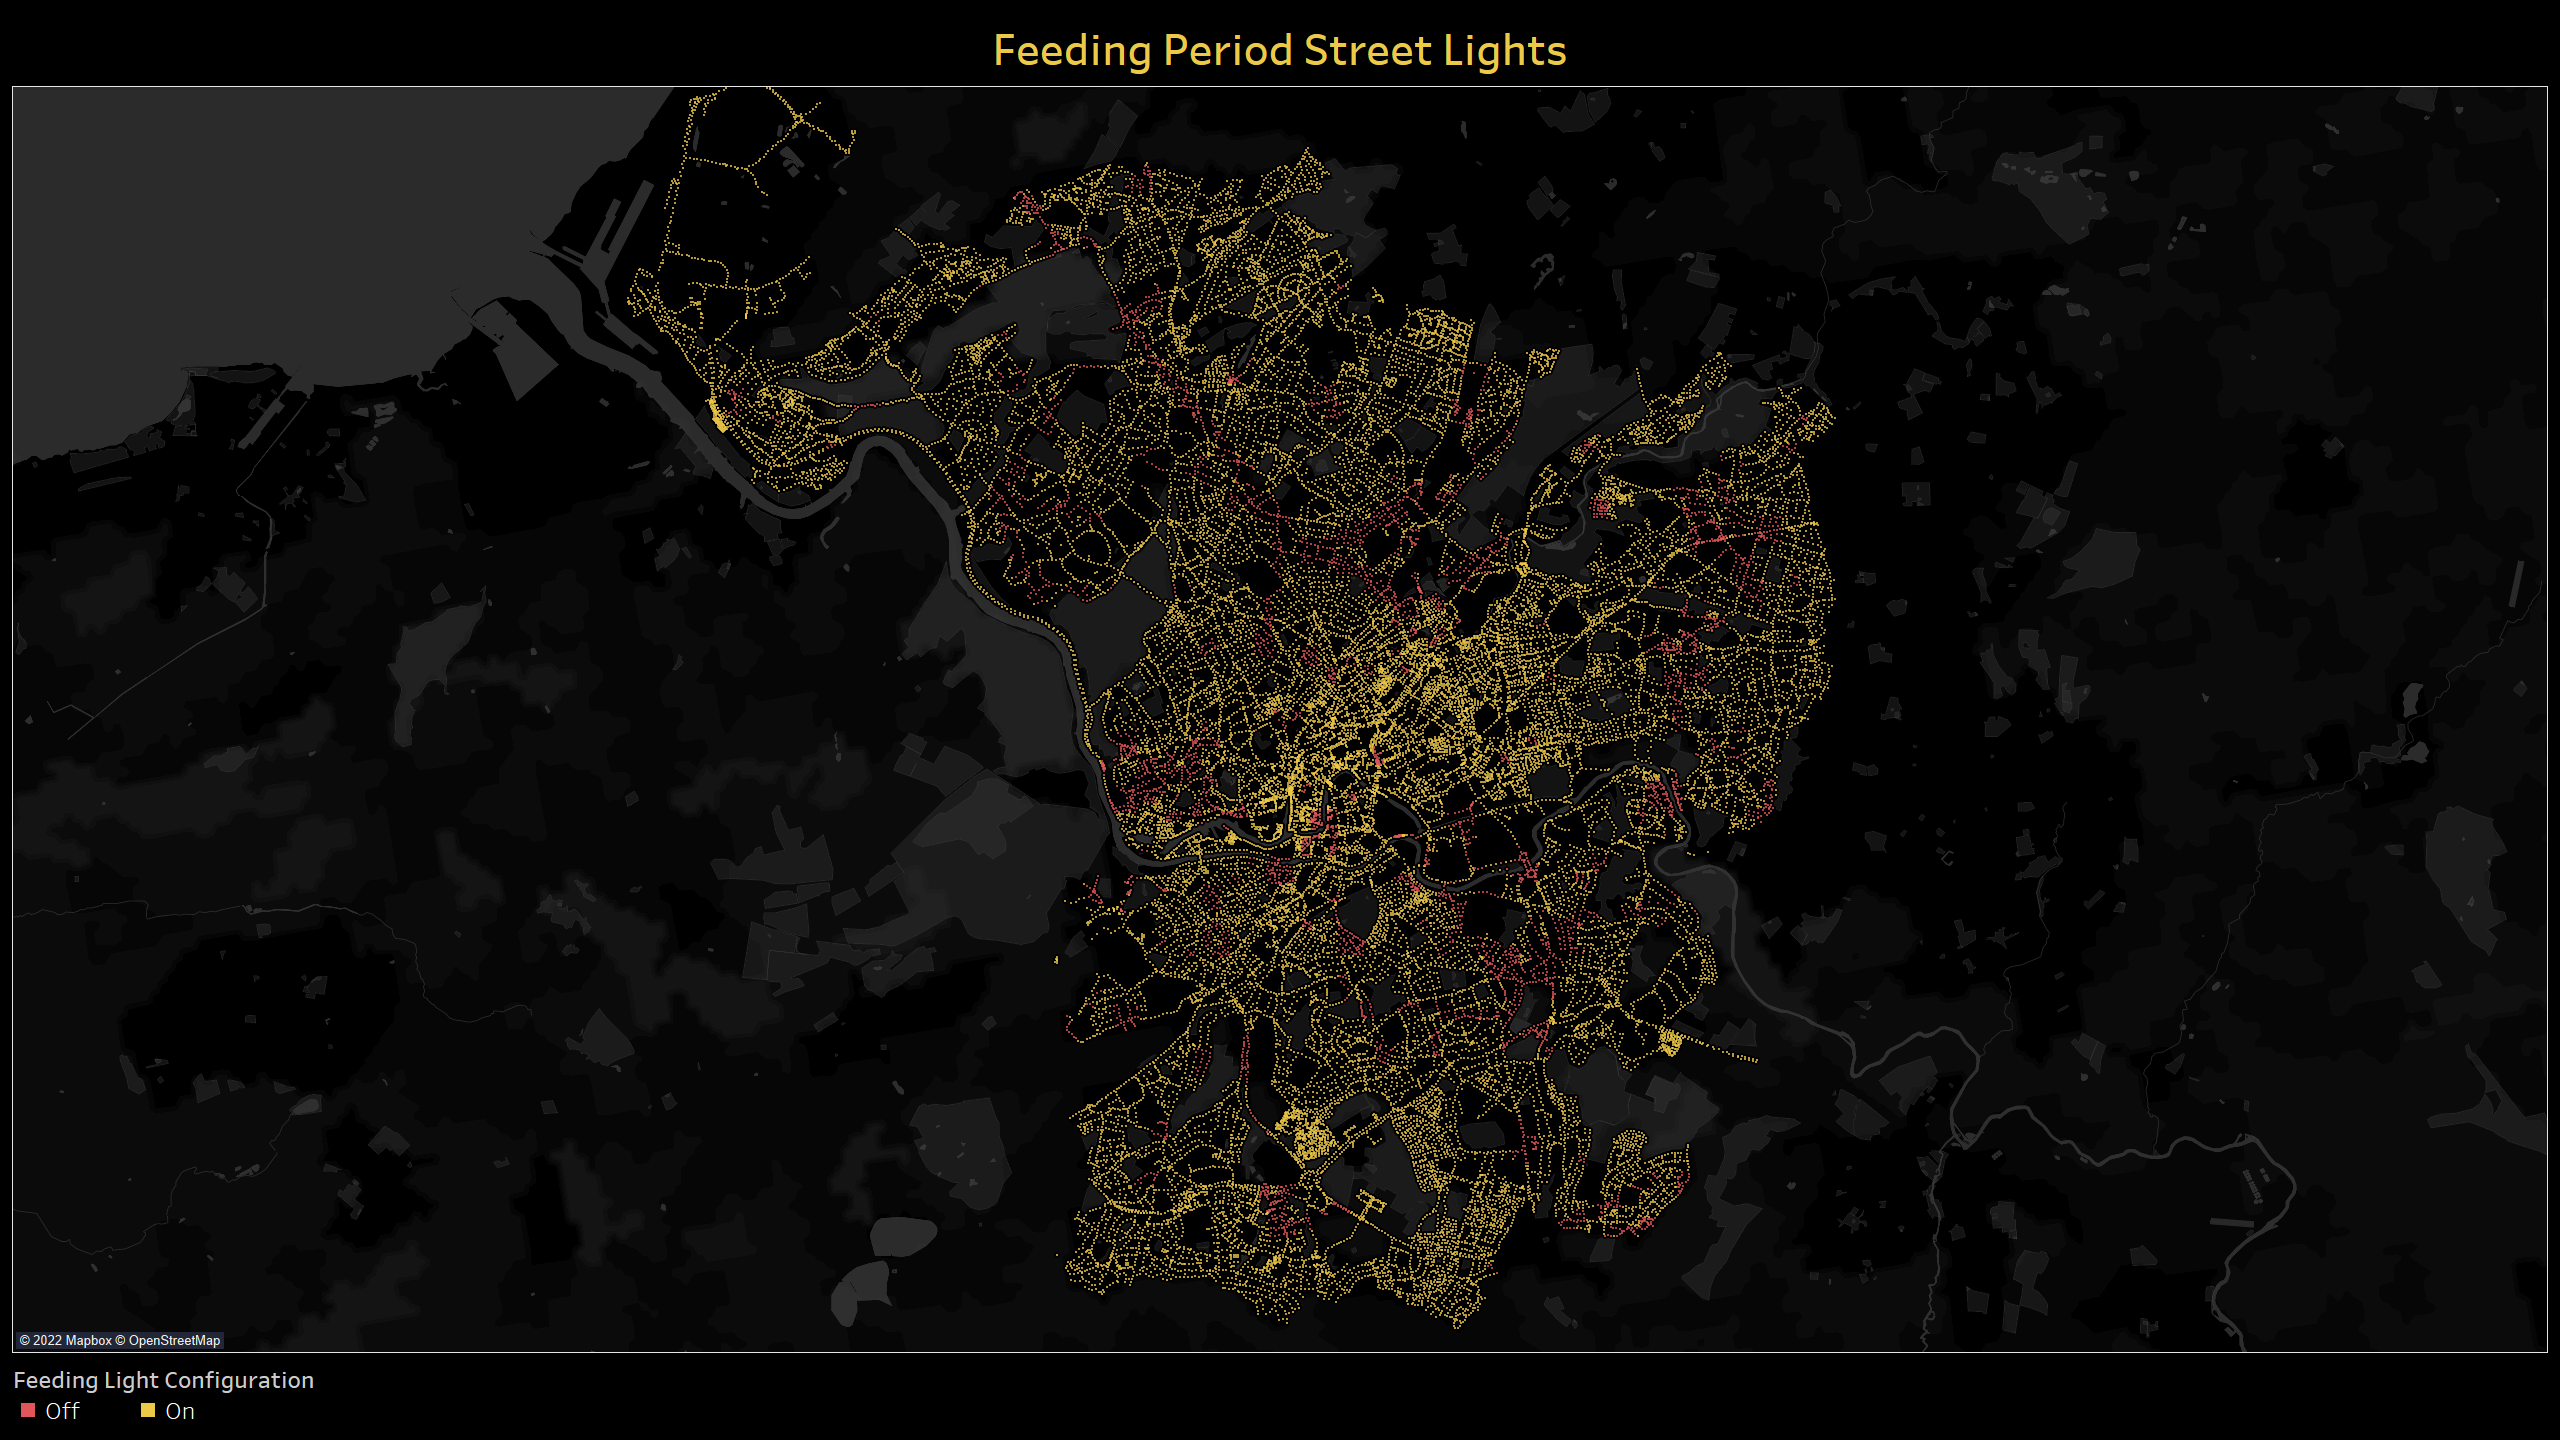

In [311]:
Image("feeding_lights.png")

This image represents the optimal light configurations for the city during bats' feeding period. We can see that paths/dark corridors have been created. The proposed solution for the feeding period not only takes into account feeding but also roosting and breeding as it turns off all of the lights that were turned off during hybernation and the additional one's that have created the dark corridors.

## 🖼️ Visualisations

Below we show some screenshots for the website we have created, which in our case is the product that has been developed.

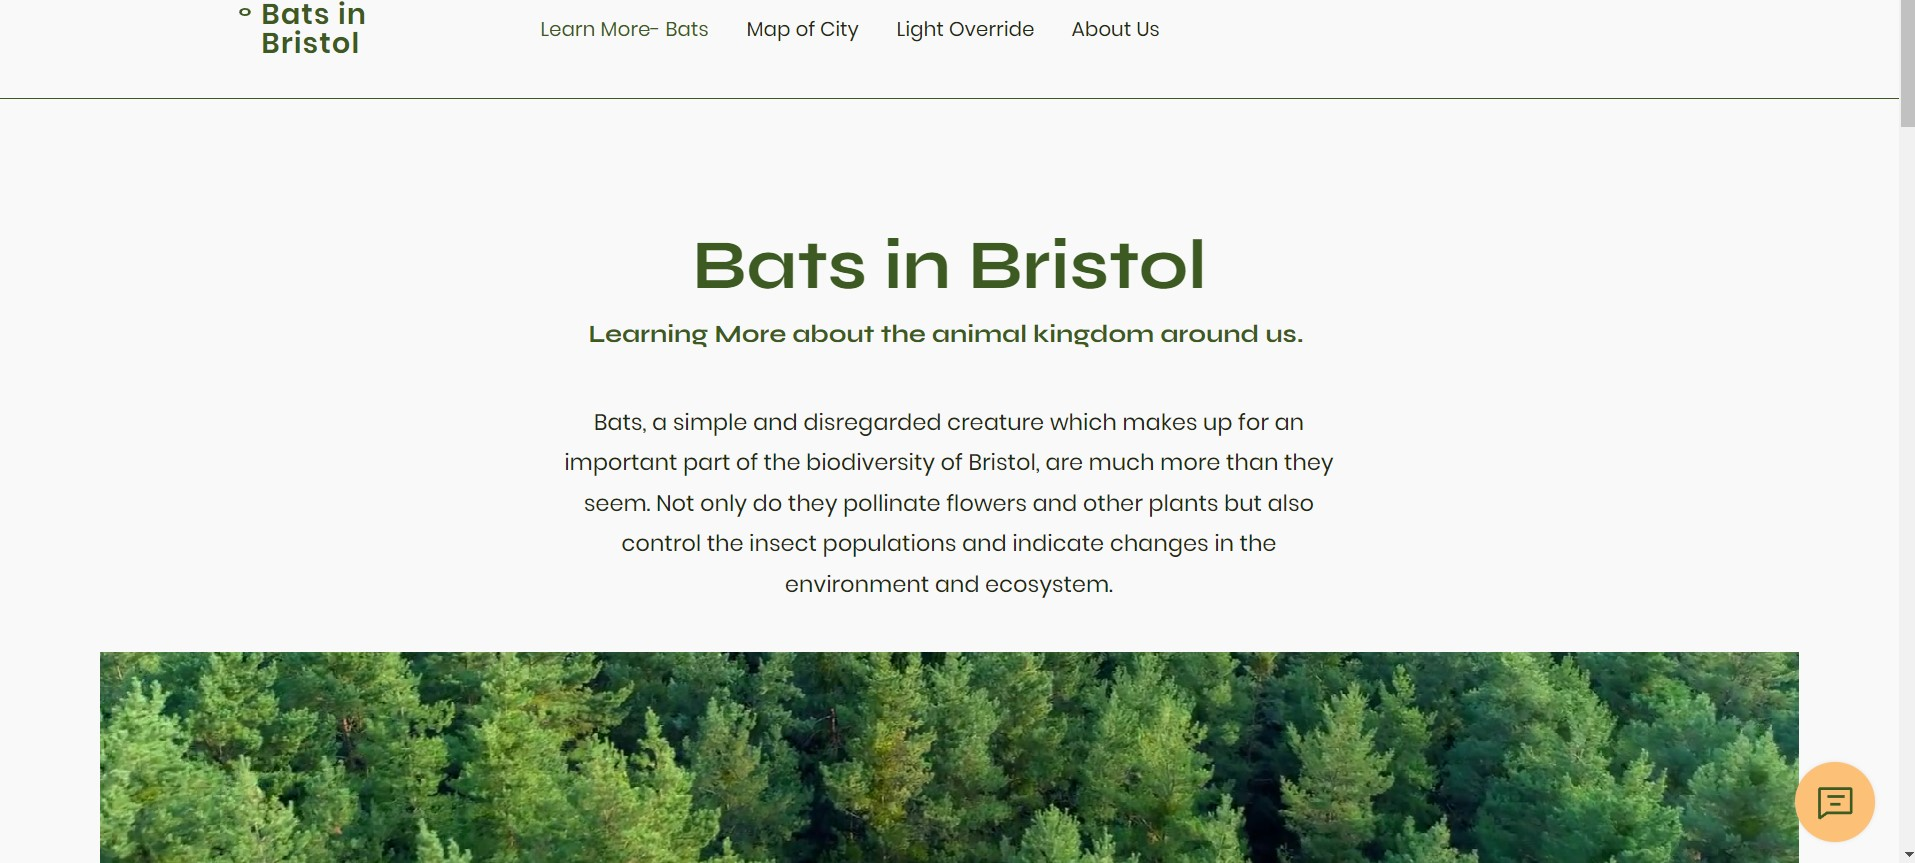

In [690]:
Image("Website_1.jpg")

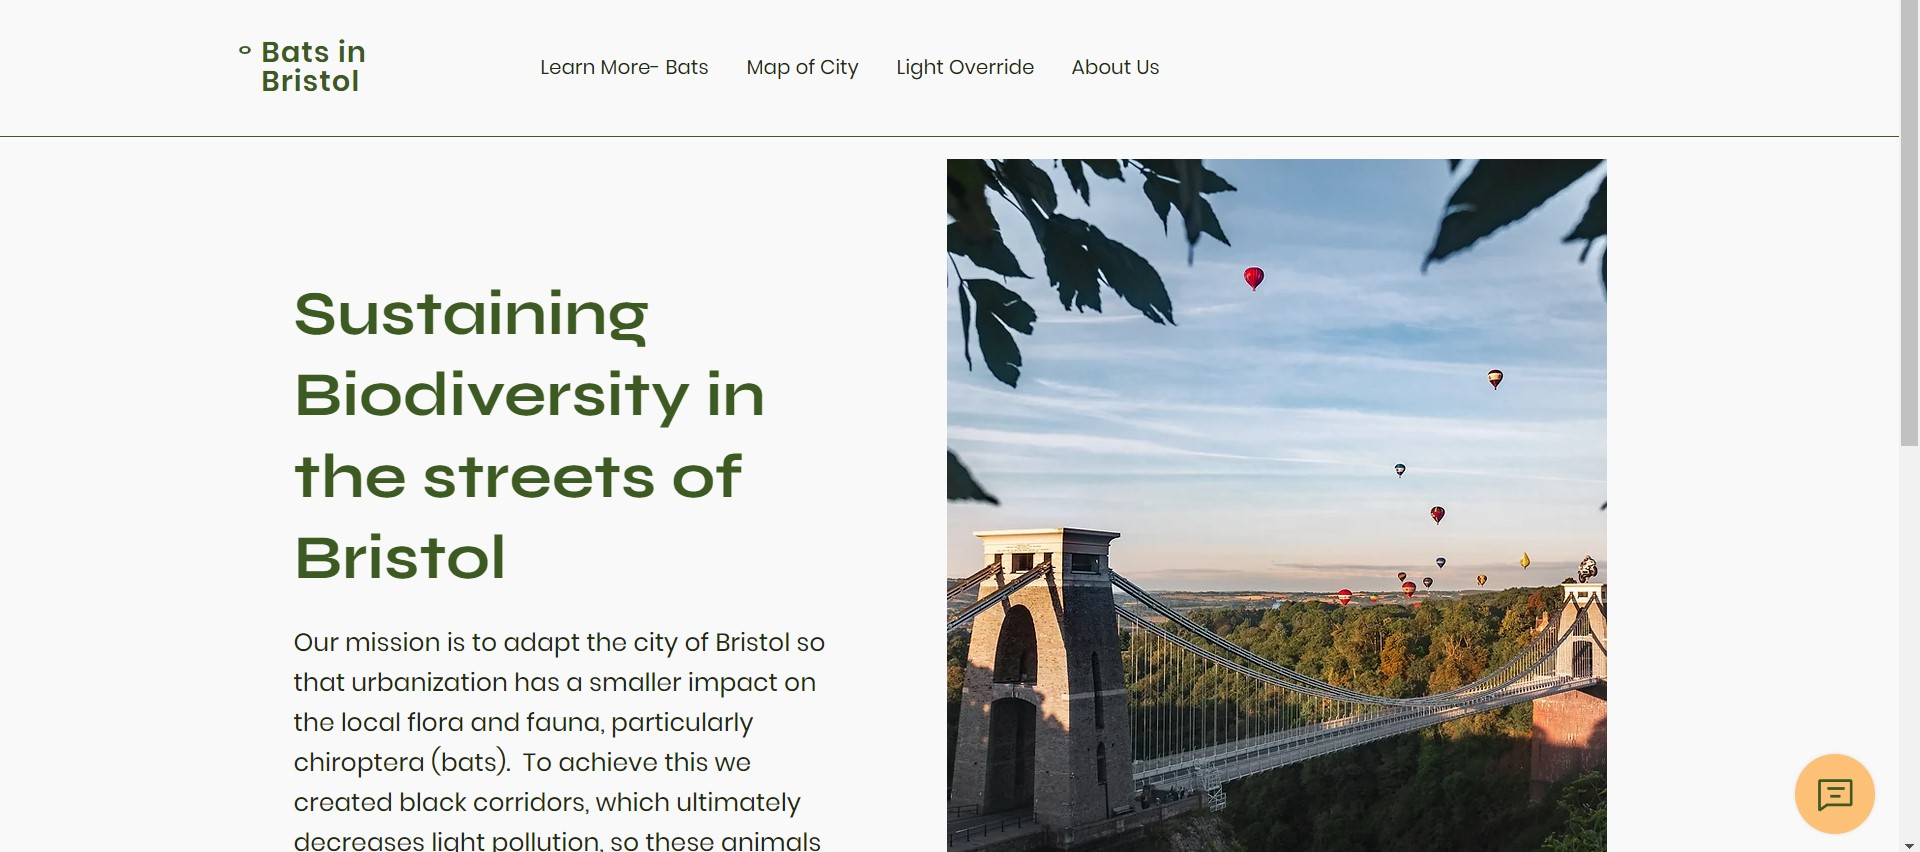

In [691]:
Image("Website_2.jpg")

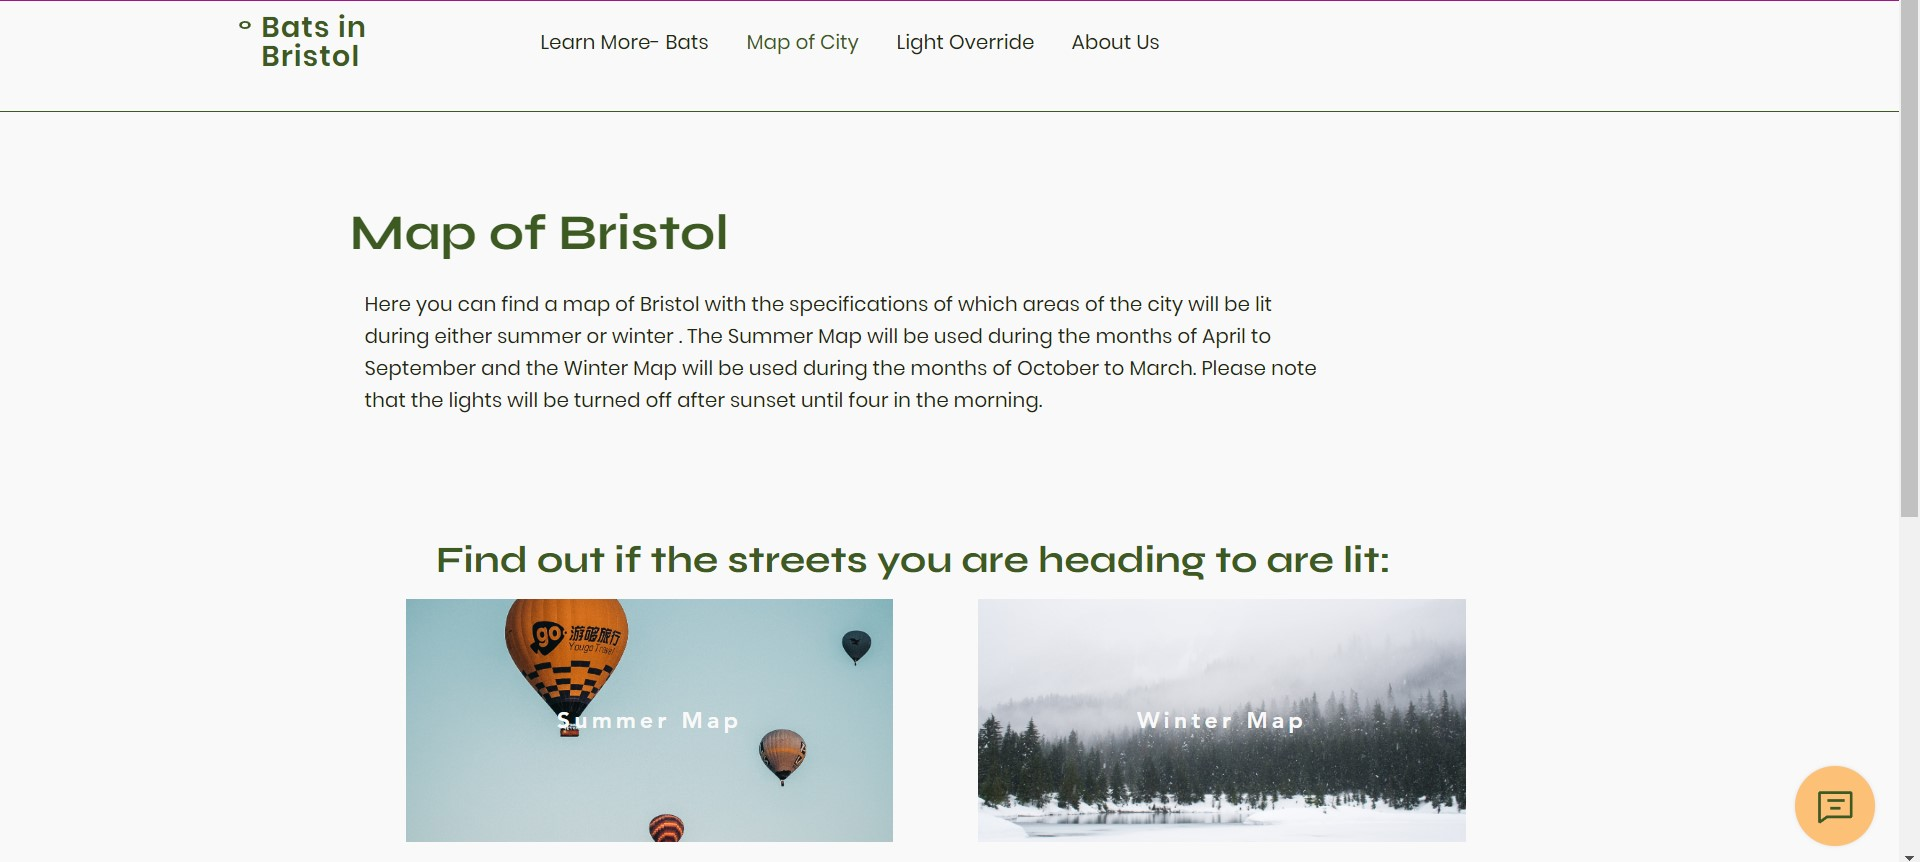

In [692]:
Image("Website_3.jpg")

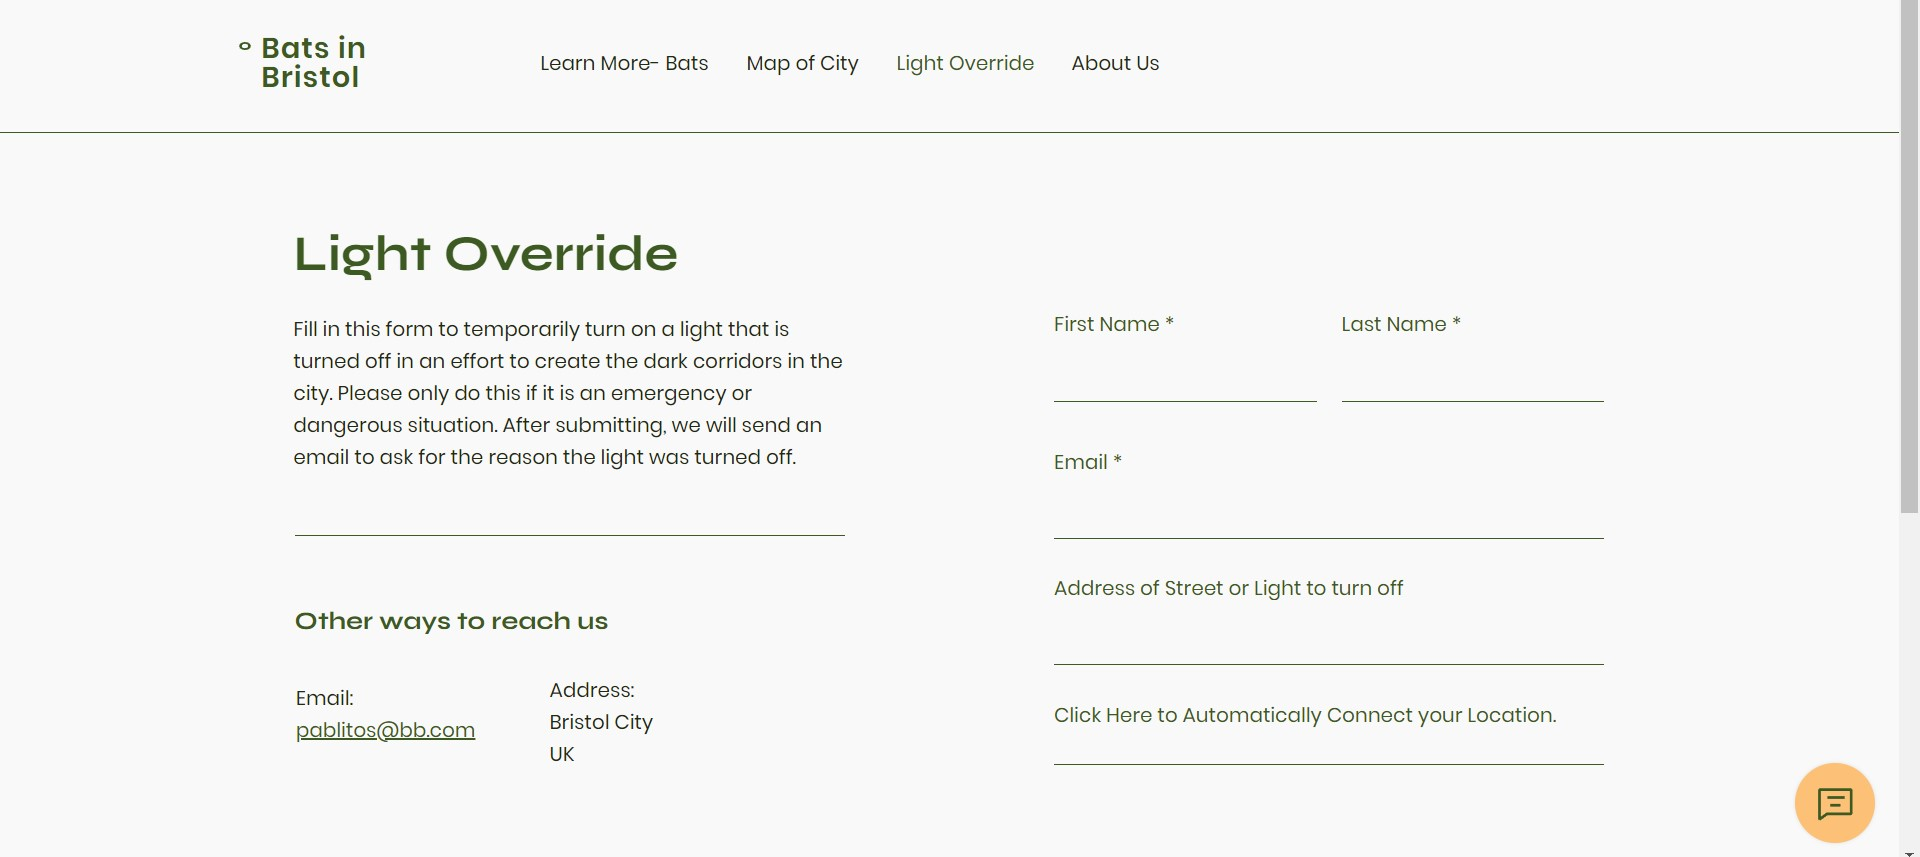

In [693]:
Image("Website_4.jpg")

## 👓 References

Link for product website: https://jrochacamargieu202.wixsite.com/bats-in-bristol

Link for google drive with all document: https://drive.google.com/drive/folders/17dFvZAkYf4TbQ57n8DEm371JqBLOlWPX?usp=sharing

https://gridreferencefinder.com/batchConvert/batchConvert.php

https://www.bats.org.uk/about-bats/where-do-bats-live/bat-roosts/roosts-in-trees.

https://opendata.bristol.gov.uk/explore/dataset/sites-of-nature-conservation-interest/information/

https://opendata.bristol.gov.uk/explore/dataset/important-open-space/map/?location=11,51.45872,-2.60825&basemap=jawg.streets

https://link.springer.com/chapter/10.1007/978-3-319-25220-9_7

Challéat, S., et al., 2021. Grasping darkness: the dark ecological network as a social-ecological framework to limit the impacts of light pollution on biodiversity. Ecology and Society 26(1):15. - 	https://www.ecologyandsociety.org/vol26/iss1/art15/ES-2020-12156.pdf

Schirmer, A.E., et al., 2019. Mapping behaviourally relevant light pollution levels to improve urban habitat planning. Scientific Reports 9, 11925 - https://rdcu.be/cDGyW

Hiding from the light - https://www.batcon.org/article/hiding-from-the-lights/

Artificial light reduces foraging opportunities in wild least horseshoe bats - https://pubmed.ncbi.nlm.nih.gov/34265558/

Protecting bats in waterside development June 2018 ba306_bath_bats_and_lighting_guide_10_june_2018.pdf (bathnes.gov.uk)

https://www.nature.com/articles/s41598-019-48118-z.epdf?sharing_token=0z5fnAAmAKcQ1rmQQP3ReNRgN0jAjWel9jnR3ZoTv0OE0sKHvgyOYH1olXfK7-gzk9lnqtdwJ3IO0T62YwuezBT4_MinsWFIi9aSpW9lkzxAO5LNLMpNR1ItWqP4-jVgWojLQ58wkd_ks3j6taXG8s7bnUJCdfhgS_x_adLmz7o%3D

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0103042

https://besjournals.onlinelibrary.wiley.com/doi/10.1111/j.1365-2664.2012.02212.x

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/228832/9780108508547.pdf.pdf

https://www.bats.org.uk/the-trust/about-us

Ecology and Society: Grasping darkness: the dark ecological network as a social-ecological framework to limit the impacts of light pollution on biodiversity

https://www.britannica.com/animal/horseshoe-bat

https://www.wildlifetrusts.org/wildlife-explorer/mammals/greater-horseshoe-bat

https://www.vwt.org.uk/wp-content/uploads/2015/04/horseshoe-bat-leaflet.pdf

https://thebristolmag.co.uk/urban-myths-bristol-bats/#:~:text=The%20most%20common%20Bristolian%20bats%20are%20thumb-sized%20pipistrelles.,or%20the%20park%20just%20after%20sunset%2C%E2%80%9D%20explained%20Stewart.

https://www.greenfinder.co.uk/the-role-of-bats-in-the-ecosystem/#:~:text=Bats%20may%20also%20serve%20as%20%E2%80%98indicator%20species%E2%80%99.%20This,problem%20in%20insect%20populations%20on%20which%20they%20depend.